# Coral Reef Environment Analysis Project

## Part 0: Preliminaries
Before you run the code of the project, you need to do the following things for preparation:
* Download the dataset https://irma.nps.gov/DataStore/Reference/Profile/2300415 and put the folder `records-2300415` in the root directory of this project
* install the following packages listed in the code block below

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import statistics as st
import numpy as np
import folium
import webbrowser
from folium.plugins import MarkerCluster
import base64
from io import BytesIO


## Part 1: Data Cleaning
We use a dataloader class to get the desired dataframe for each problem.

In [8]:
class Data_loader:
    def __init__(self, data_dir = './records-2300415/'):
        self._data_dir = data_dir
        self._location_columns = ["Location_ID","Latitude", "Latitude_Dir", "Longitude", "Longitude_Dir", "Site_ID","Island","Subunit","Loc_Name","Loc_Type","GCS","Management","Depth","Loc_status"]
        self._df_Locations = self._df_preprocess(pd.read_csv("{}tbl_Locations.csv".format(data_dir)))[self._location_columns]
        self._df_Events = self._df_preprocess(pd.read_csv("{}tbl_Events.csv".format(data_dir)))

    def _df_ID_formatting(self, df:pd.DataFrame):
        """
        format the IDs in the dataframe into the same type format
        """
        for col_name in [name for name in df.columns.values.tolist() if "ID" in name]:
            df[col_name] = df[col_name].astype(str)
        return df

    def _df_date_formatting(self, df:pd.DataFrame, period='M', date_names=None):
        """
        The function converts the date columns in specific dataframe to period format
        eg: Period('2018-3', 'M') # the period in months
        
        Inputs:
        df (pd.Dataframe): the dataframe to be processed
        period (str): the period of time, 'Y': year, 'M': month, 'D': day
        date_names (list): the names of the date list to be changed, if not specified, change
        all the date columns
        Ouput:
        (pd.Dataframe) the update dataframe
        """
        if date_names is None:
            for col_name in [name for name in df.columns.values.tolist() if "Date" in name]:
                df[col_name] = pd.to_datetime(df[col_name])
                df[col_name] = df[col_name].dt.to_period(period)
            return df
        else:
            for col_name in date_names:
                df[col_name] = pd.to_datetime(df[col_name])
                df[col_name] = df[col_name].dt.to_period(period)
            return df

    def _df_preprocess(self, df:pd.DataFrame, period='M'):
        """
        preprocess the dataframes to format its types
        """
        df = self._df_ID_formatting(df)
        df = self._df_date_formatting(df, period=period)
        return df

class Data_loader_coral_reef_health(Data_loader):
    """
    This class is dataloader to investigate the coral reef health
    It focus on two things:
    1. time location vs bleaching
    2. time location vs rugosity (heterogeneity)
    """
    def __init__(self, data_dir='./records-2300415/'):
        self._df_benthic_cover = super()._df_preprocess(pd.read_csv("{}tbl_Benthic_Cover.csv".format(data_dir)))
        self._df_Rugosity = super()._df_preprocess(pd.read_csv("{}tbl_Rugosity.csv".format(data_dir)))
        self._bleaching_columns = ['Event_ID', 'Location_ID', "Latitude", "Latitude_Dir", "Longitude", "Longitude_Dir", 'Start_Date', 'Rugosity', 'Entered_Date', 'Benthic_ID', 'Frame', 'Disease_Bleaching', 'Severity', 'Island']
        self._rugosity_columns = ['Event_ID', 'Location_ID', "Latitude", "Latitude_Dir", "Longitude", "Longitude_Dir", 'Start_Date', 'Rugosity', 'Entered_Date', "Chain_length", "Tape_length", 'Island']
        self._location_columns = []
        # rugosity here refers to wehter the df contain such column, disease bleaching is yes or no
        super().__init__(data_dir)


    def get_df_time_location_bleaching(self):
        # get time & location vs bleaching
        df_time_loc_bleaching = self._df_Events.merge(self._df_benthic_cover, on='Event_ID', how="inner")
        df_time_loc_bleaching = df_time_loc_bleaching.merge(self._df_Locations, on='Location_ID', how='inner')[self._bleaching_columns]
        df_time_loc_bleaching = df_time_loc_bleaching[df_time_loc_bleaching["Latitude"].notna()]
        return df_time_loc_bleaching
    
    def get_df_time_location_bleaching_severity(self):
        # get time & location vs bleaching with severity
        df = self._df_Events.merge(self._df_benthic_cover, on='Event_ID', how="inner")
        df = df.merge(self._df_Locations, on='Location_ID', how='inner')[self._bleaching_columns]
        df = df[df["Severity"].notna()]
        df = df[df["Latitude"].notna()]
        return df

   
    
    def get_df_time_loc_rugosity(self):
        df_time_loc_rugosity = self._df_Events.merge(self._df_Rugosity, on='Event_ID', how="inner")
        df_time_loc_rugosity["Heterogeneity"] = df_time_loc_rugosity["Chain_length"] / df_time_loc_rugosity["Tape_length"]
        df_time_loc_rugosity = df_time_loc_rugosity.merge(self._df_Locations, on='Location_ID', how='left')
        df_time_loc_rugosity = df_time_loc_rugosity[df_time_loc_rugosity["Latitude"].notna()]
        return df_time_loc_rugosity

class Data_Loader_biomass_density_change(Data_loader):
    """
    This class is dataloader to measure biomass density change and species size change at the coral reef over time
    It focus on two things:
    1. time vs fish density
    2. time vs juvenile colony size
    """
    def __init__(self, data_dir='./records-2300415/'):
        self._df_Fish = super()._df_preprocess(pd.read_csv("{}tbl_Fish.csv".format(data_dir)))
        self._df_Juvenile_Colony = self._df_preprocess_juvenile_colony(pd.read_csv("{}tbl_Juvenile_Colony.csv".format(data_dir)))
        self._df_Settlement = super()._df_preprocess(pd.read_csv("{}tbl_Settlement.csv".format(data_dir)))
        self._df_Surfaces = super()._df_preprocess(pd.read_csv("{}tbl_Surfaces.csv".format(data_dir)))
        self._df_Taxons = super()._df_preprocess(pd.read_csv("{}tlu_Taxon.csv".format(data_dir)))
        self._fish_density_columns = ['Fish_ID', 'Event_ID', 'Taxon_ID', 'Location_ID', 'Start_Date', 'Entered_Date', 'Number', 'Area']
        self._fish_density_taxon_columns = ['Fish_ID', 'Event_ID', 'Taxon_ID', "Taxon_Name", "Type", 'Location_ID', 'Start_Date', 'Entered_Date', 'Number', 'Area']
        self._fish_density_taxon_loc_columns = ['Fish_ID', 'Event_ID', 'Taxon_ID', "Taxon_Name", "Type", 'Location_ID', "Latitude", "Latitude_Dir", "Longitude", "Longitude_Dir", 'Island', 'Subunit', 'Loc_Name', 'Start_Date', 'Entered_Date', 'Number', 'Area', 'Density']
        self._juvenile_surface_columns = ["Juv_Colony_ID", "Surface_ID", "Settlement_ID", "Taxon_ID", "Genus_code", "Ind_Count", "Length_mm", "Width_mm"]
        self._juvenile_settlement_columns = ["Juv_Colony_ID", "Surface_ID", "Settlement_ID", "Event_ID", "Taxon_ID", "Genus_code", "Ind_Count", "Length_mm", "Width_mm"]
        self._time_juvenile_size_columns = ["Juv_Colony_ID", "Surface_ID", "Settlement_ID", "Event_ID", "Taxon_ID", "Location_ID", 'Start_Date', 'Entered_Date', "Genus_code", "Ind_Count", "Length_mm", "Width_mm"]
        self._time_juvenile_size_taxon_columns = ["Juv_Colony_ID", "Surface_ID", "Settlement_ID", "Event_ID", "Taxon_ID", "Location_ID", "Taxon_Name", "Type", 'Start_Date', 'Entered_Date', "Genus_code", "Ind_Count", "Length_mm", "Width_mm"]
        self._time_juvenile_size_taxon_loc_columns = ["Juv_Colony_ID", "Surface_ID", "Settlement_ID", "Event_ID", "Taxon_ID", "Location_ID", "Latitude", "Latitude_Dir", "Longitude", "Longitude_Dir", 'Island', 'Subunit', 'Loc_Name', "Taxon_Name", "Type", 'Start_Date', 'Entered_Date', "Genus_code", "Ind_Count", "Length_mm", "Width_mm"]
        # self._juvenile_density_columns = ['Event_ID', 'Location_ID', 'Start_Date', 'Rugosity', 'Entered_Date', "Chain_length", "Tape_length"]
        
        super().__init__(data_dir)

    def _df_preprocess_juvenile_colony(self, df_juvenile_colony: pd.DataFrame):
        """
        Pre-process juvenile colony table by elimicating rows with incomplete information
        """
        df_juvenile_colony = super()._df_preprocess(df_juvenile_colony)
        df_juvenile_colony = df_juvenile_colony[df_juvenile_colony["Ind_Count"].notna()]
        return df_juvenile_colony

    def get_df_time_fish_density(self):
        """
        Get dataframe containing event time (in month) and fish groups' density
        """
        # get fish density variations over time
        df_time_fish_density = self._df_Fish.merge(self._df_Events, on='Event_ID', how="inner")[self._fish_density_columns]
        df_time_fish_density_taxon = df_time_fish_density.merge(self._df_Taxons, on='Taxon_ID', how="inner")[self._fish_density_taxon_columns]
        # clean out fish groups with unknown taxon name
        df_time_fish_density_taxon = df_time_fish_density_taxon[df_time_fish_density_taxon["Taxon_Name"].notna()]
        # compute fish density given per group of fish (number per unit area)
        df_time_fish_density_taxon["Density"] = df_time_fish_density_taxon["Number"] / df_time_fish_density_taxon["Area"]
        df_time_fish_density_taxon_loc = df_time_fish_density_taxon.merge(self._df_Locations, on='Location_ID', how="inner")[self._fish_density_taxon_loc_columns]
        df_time_fish_density_taxon_loc = df_time_fish_density_taxon_loc[df_time_fish_density_taxon_loc["Island"].notna()]
        df_time_fish_density_taxon_loc = df_time_fish_density_taxon_loc[df_time_fish_density_taxon_loc["Latitude"].notna()]
        # Possible analysis TODO: Group density by months (either given Taxons or not) or 
        #                         Taxons (given months) using average, and plot the density change 
        #                         trend w.r.t. time/Taxon.
        return df_time_fish_density_taxon_loc
    
    def get_df_time_juvenile_size(self):
        """
        Get dataframe containing event time (in month) and the sizes of the juvenile colonies discovered
        """
        # get juvenile species size variations over time
        df_juvenile_surface = self._df_Juvenile_Colony.merge(self._df_Surfaces, on='Surface_ID', how="inner")[self._juvenile_surface_columns]
        df_juvenile_settlement = df_juvenile_surface.merge(self._df_Settlement, on='Settlement_ID', how="inner")[self._juvenile_settlement_columns]
        df_time_juvenile_size = df_juvenile_settlement.merge(self._df_Events, on='Event_ID', how="inner")[self._time_juvenile_size_columns]
        df_time_juvenile_size_taxon  = df_time_juvenile_size.merge(self._df_Taxons, on='Taxon_ID', how="inner")[self._time_juvenile_size_taxon_columns]
        df_time_juvenile_size_taxon_loc = df_time_juvenile_size_taxon.merge(self._df_Locations, on='Location_ID', how="inner")[self._time_juvenile_size_taxon_loc_columns]
        # clean out juveniles with unknown location information
        df_time_juvenile_size_taxon_loc = df_time_juvenile_size_taxon_loc[df_time_juvenile_size_taxon_loc["Island"].notna()]
        # clean out juveniles with unknown taxon name
        df_time_juvenile_size_taxon_loc = df_time_juvenile_size_taxon_loc[df_time_juvenile_size_taxon_loc["Taxon_Name"].notna()]
        df_time_juvenile_size_taxon_loc = df_time_juvenile_size_taxon_loc[df_time_juvenile_size_taxon_loc["Latitude"].notna()]
        # compute sizes of juvenile individuals
        df_time_juvenile_size_taxon_loc["Size_mm"] = df_time_juvenile_size_taxon_loc["Length_mm"]*df_time_juvenile_size_taxon_loc["Width_mm"]
        # Possible analysis TODO: Group Size by Taxon using average, and measure the species size change 
        #                         across time given a Taxon.
        return df_time_juvenile_size_taxon_loc


In [9]:
# example usage of the dataloader
data_loader_health_temp = Data_loader_coral_reef_health()
data_loader_biomass_temp = Data_Loader_biomass_density_change()
print(data_loader_health_temp.get_df_time_loc_rugosity().columns.values, len(data_loader_health_temp.get_df_time_loc_rugosity()))
print(data_loader_health_temp.get_df_time_location_bleaching().columns.values, len(data_loader_health_temp.get_df_time_location_bleaching()))
print(data_loader_biomass_temp.get_df_time_fish_density().columns.values, len(data_loader_biomass_temp.get_df_time_fish_density()))
print(data_loader_biomass_temp.get_df_time_juvenile_size().columns.values, len(data_loader_biomass_temp.get_df_time_juvenile_size()))

['Event_ID' 'Location_ID' 'Protocol_Name' 'Start_Date' 'Notes' 'Rugosity'
 'Entered_by' 'Entered_Date' 'Updated_Date' 'Fish_Certified'
 'Fish_Certified_by' 'Fish_Certified_Date' 'QA_notes' 'Chain_length'
 'Tape_length' 'Heterogeneity' 'Latitude' 'Latitude_Dir' 'Longitude'
 'Longitude_Dir' 'Site_ID' 'Island' 'Subunit' 'Loc_Name' 'Loc_Type' 'GCS'
 'Management' 'Depth' 'Loc_status'] 993
['Event_ID' 'Location_ID' 'Latitude' 'Latitude_Dir' 'Longitude'
 'Longitude_Dir' 'Start_Date' 'Rugosity' 'Entered_Date' 'Benthic_ID'
 'Frame' 'Disease_Bleaching' 'Severity' 'Island'] 36115
['Fish_ID' 'Event_ID' 'Taxon_ID' 'Taxon_Name' 'Type' 'Location_ID'
 'Latitude' 'Latitude_Dir' 'Longitude' 'Longitude_Dir' 'Island' 'Subunit'
 'Loc_Name' 'Start_Date' 'Entered_Date' 'Number' 'Area' 'Density'] 55662
['Juv_Colony_ID' 'Surface_ID' 'Settlement_ID' 'Event_ID' 'Taxon_ID'
 'Location_ID' 'Latitude' 'Latitude_Dir' 'Longitude' 'Longitude_Dir'
 'Island' 'Subunit' 'Loc_Name' 'Taxon_Name' 'Type' 'Start_Date'
 'Entered

## Part II: Data Analysis
In the part, we focus on two questions:
1. The change in the coral reef health
2. The change in the coral reef biological conditions

### Part II.a: Coral Reef Health Analysis
We analyze the coral reef health by investigating bleaching and rugosity (heterogeneity)
The code in the following block visualize:
1. bealching vs location, time
2. rugosity vs location, time

In [10]:
data_loader = Data_loader_coral_reef_health()

def vis_rugosity(parameter = 'loc'):
    """
    Generates visualisations about rugosity of coral reefs vs time and location
    

    Parameters
    ----------
    parameter : string, optional
        what type of visualisation loc or time

    Returns
    -------
    None.

    """

    df_time_loc_rugosity = data_loader.get_df_time_loc_rugosity()
    
    if parameter == 'loc':
        
        fig, axes = plt.subplots(3, 2, figsize=(10, 10))  # Adjust rows/cols as needed
        
        grouped_loc = df_time_loc_rugosity.groupby("Island")
    
        for i, (island, data) in enumerate(grouped_loc):
            ax = axes.flatten()[i]
            data["Heterogeneity"].plot.hist(ax=ax, label=island)
            ax.set_title(f"Island: {island}")
            ax.set_xlabel("Heterogeneity")
            ax.set_ylabel("Count")
                
        fig.suptitle("Heterogeneity Distribution by Site ID")
        plt.tight_layout()
        plt.show()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

        # Island histogram
        for island in df_time_loc_rugosity['Island'].unique():
            island_data = df_time_loc_rugosity[df_time_loc_rugosity['Island'] == island]['Heterogeneity']
            ax1.hist(island_data, label=island, alpha=0.6)

        # Heterogeneity distribution
        ax2.hist(df_time_loc_rugosity['Heterogeneity'], label='Overall')

        ax1.set_xlabel('Heterogeneity')
        ax1.set_ylabel('Count')
        ax1.set_title('Island-wise Heterogeneity distribution')
        ax2.set_xlabel('Heterogeneity')
        ax2.set_ylabel('Count')
        ax2.set_title('Overall Heterogeneity distribution')

        ax1.legend()
        plt.tight_layout()
        plt.show()
        
    if parameter == 'time':
        df_time_loc_rugosity['Start_Date_Num'] = df_time_loc_rugosity['Start_Date'].dt.to_timestamp()
        
        for i in df_time_loc_rugosity['Island'].unique():
        
            df_time_loc_rugosity_temp = df_time_loc_rugosity[df_time_loc_rugosity['Island'] == i]
            df_temp = df_time_loc_rugosity_temp[['Start_Date_Num', 'Heterogeneity']].groupby('Start_Date_Num').mean()
            df_temp['het_avg'] = df_temp['Heterogeneity'].rolling(window=3).mean()
            plt.plot(df_temp.index, df_temp['het_avg'], label=i)
    
            plt.xlabel('Start Date')
            plt.ylabel('Heterogeneity')
            plt.title('Heterogeneity over Time')

        plt.legend()
        plt.show()
        
def vis_bleach(type = "loc"):
    """
    Generates visualisations about bleaching of coral reefs vs time and location

    Parameters
    ----------
    p
    type : string, optional
        DESCRIPTION. The default is "count".

    Returns
    -------
    df_het_10 : TYPE
        DESCRIPTION.

    """
    
    df_time_loc_bleaching = data_loader.get_df_time_location_bleaching_severity()
    df_time_loc_bleaching['Start_Date_Num'] = df_time_loc_bleaching['Start_Date'].dt.to_timestamp()
    # df_het_10 = df_time_loc_bleaching[df_time_loc_bleaching['Location_ID'] == '{005A1863-5D44-4E62-B251-C5E650E31EAF}']
    df_het_10 = df_time_loc_bleaching
    df_het_10 = df_het_10[df_het_10['Disease_Bleaching'] == 'Yes']
    class_mapping = {'No Coral':0, '0%' : 1, '1-25%': 2, '26-50%': 3, '51-75%': 4, '76-100%': 5}
    df_het_10['sev_numeric'] = df_het_10['Severity'].map(class_mapping) 
    # df_het_10['sev_numeric_avg'] = df_het_10['sev_numeric'].rolling(window=3).mean()
    # df_het_10['db_avg'] = df_het_10['Disease_Bleaching'].rolling(window=5).mean()
    # Plot using the numerical representation of 'Entered_Date'
    
    if type == 'loc':
        
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Adjust rows/cols as needed
        
        grouped_loc = df_het_10.groupby("Island")
    
        for i, (island, data) in enumerate(grouped_loc):
            ax = axes.flatten()[i]
            data["sev_numeric"].plot.hist(ax=ax, label=island)
            ax.set_title(f"Island: {island}")
            ax.set_xlabel("Heterogeneity")
            ax.set_ylabel("Count")
                
        fig.suptitle("Heterogeneity Distribution by Site ID")
        plt.tight_layout()
        plt.show()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

        # Island histogram
        for island in df_het_10['Island'].unique():
            island_data = df_het_10[df_het_10['Island'] == island]['sev_numeric']
            ax1.hist(island_data, label=island, alpha=0.6)

        # Heterogeneity distribution
        ax2.hist(df_het_10['sev_numeric'], label='Overall')

        # Set labels and title
        ax1.set_xlabel('Heterogeneity')
        ax1.set_ylabel('Count')
        ax1.set_title('Island-wise Heterogeneity distribution')
        ax2.set_xlabel('Heterogeneity')
        ax2.set_ylabel('Count')
        ax2.set_title('Overall Heterogeneity distribution')

        ax1.legend()
        plt.tight_layout()
        plt.show()
    
    
    if type == 'severity':
        
        df_temp = df_het_10[['Start_Date_Num', 'sev_numeric']].groupby('Start_Date_Num').mean()
        df_temp['sev_avg'] = df_temp['sev_numeric'].rolling(window=4).mean()
    
        plt.scatter(df_temp.index, df_temp['sev_avg'])
    
        # You can customize the plot further if needed
        plt.xlabel('Start Date')
        plt.ylabel('Bleaching Severity')
        plt.title('Avg bleaching severity over time')
        
        plt.show()
    
    if type == 'count':
    # df_temp = df_het_10[['Entered_Date_Num', 'sev_numeric_avg']].groupby('Entered_Date_Num').median()
        df_temp = df_het_10[['Start_Date_Num', 'Disease_Bleaching']].groupby('Start_Date_Num').count()
        df_temp['db_avg'] = df_temp['Disease_Bleaching'].rolling(window=3).mean()
        plt.scatter(df_temp.index, df_temp['db_avg'])
    
        # You can customize the plot further if needed
        plt.xlabel('Start Date')
        plt.ylabel('Count of Disease Bleaching')
        plt.title('Avg bleaching case count over time')

        plt.show()

    # return df_temp

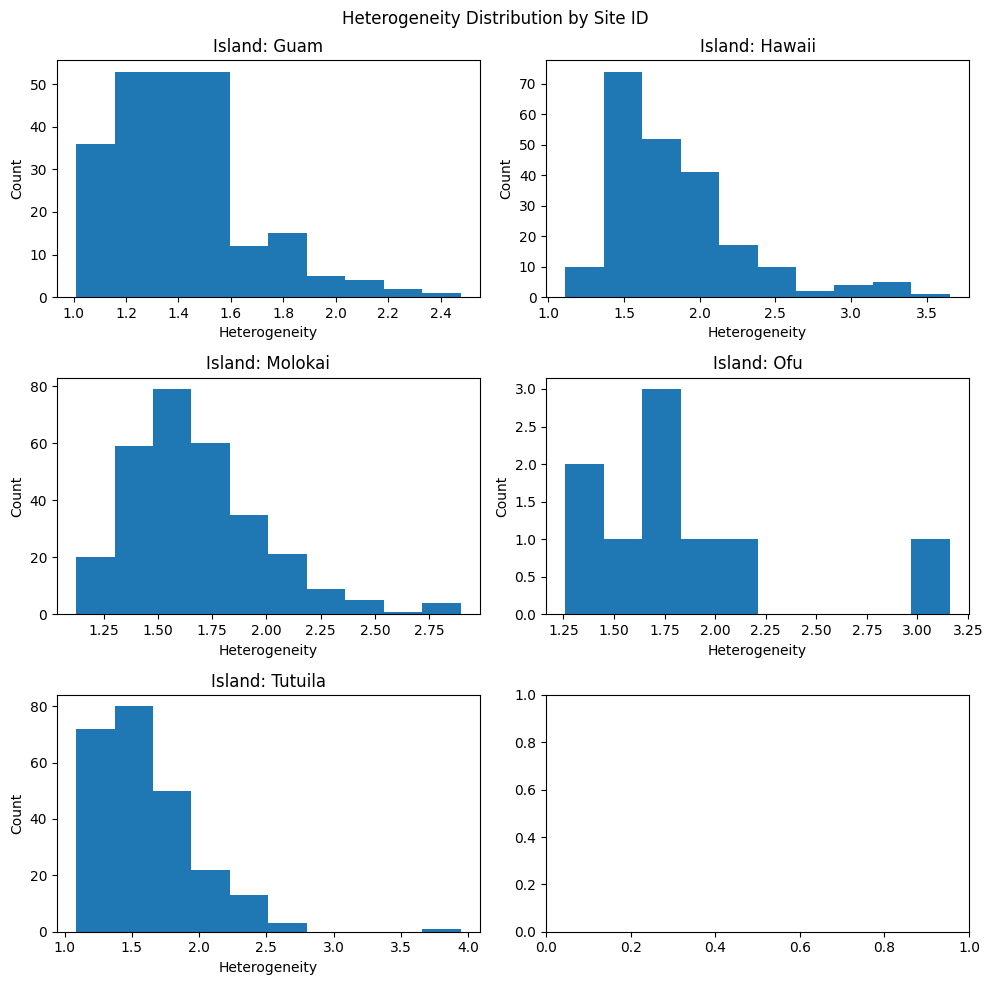

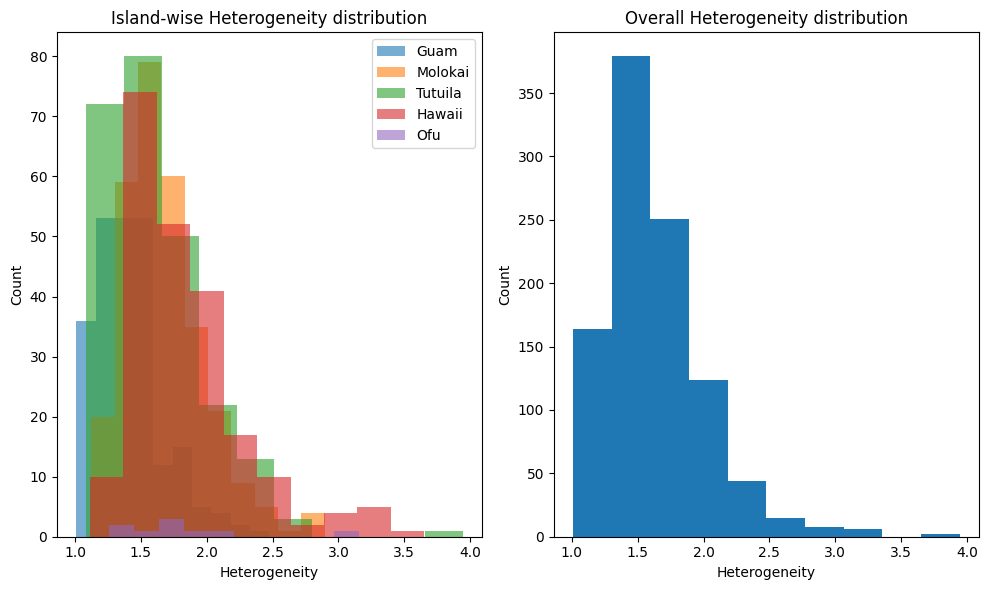

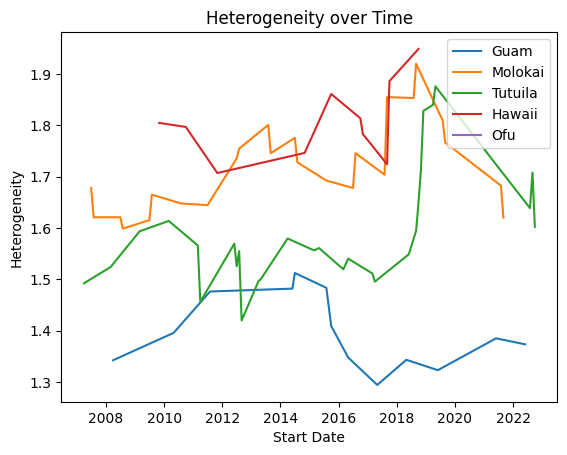

/tmp/ipykernel_36211/2096691224.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_het_10['sev_numeric'] = df_het_10['Severity'].map(class_mapping)


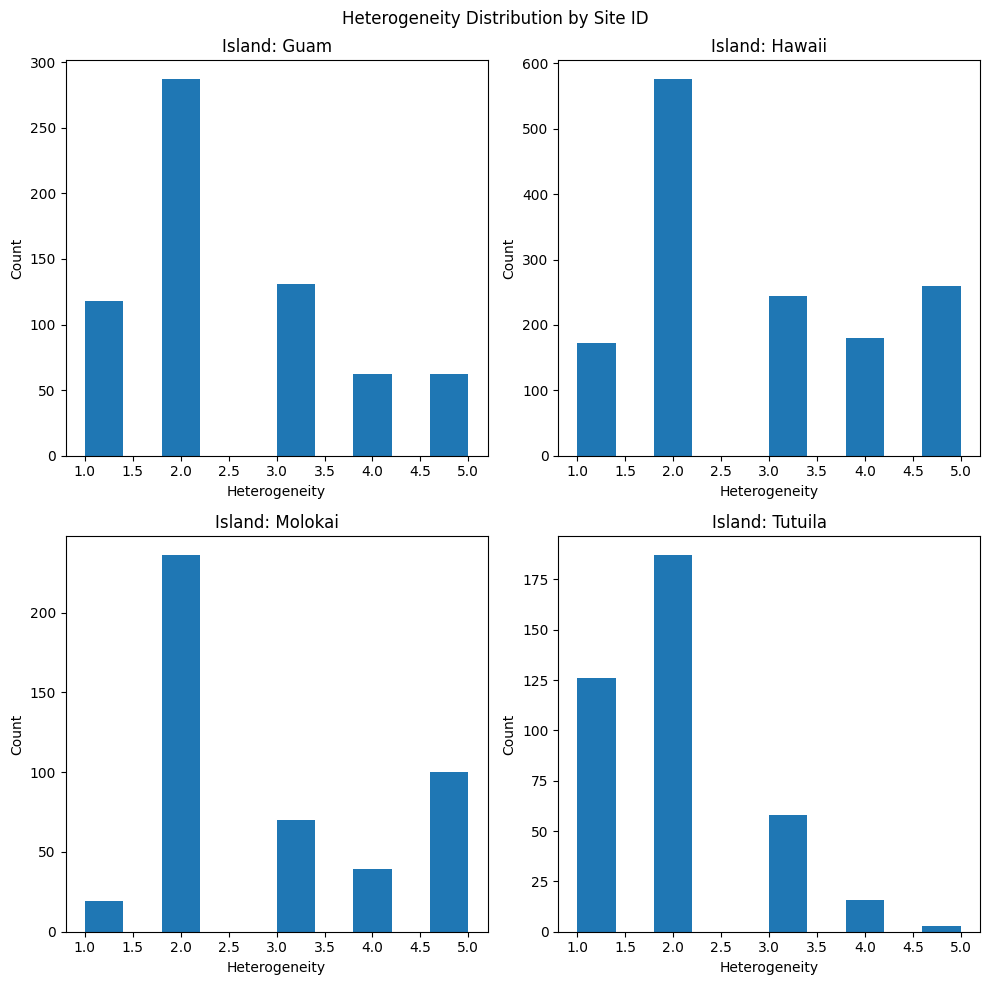

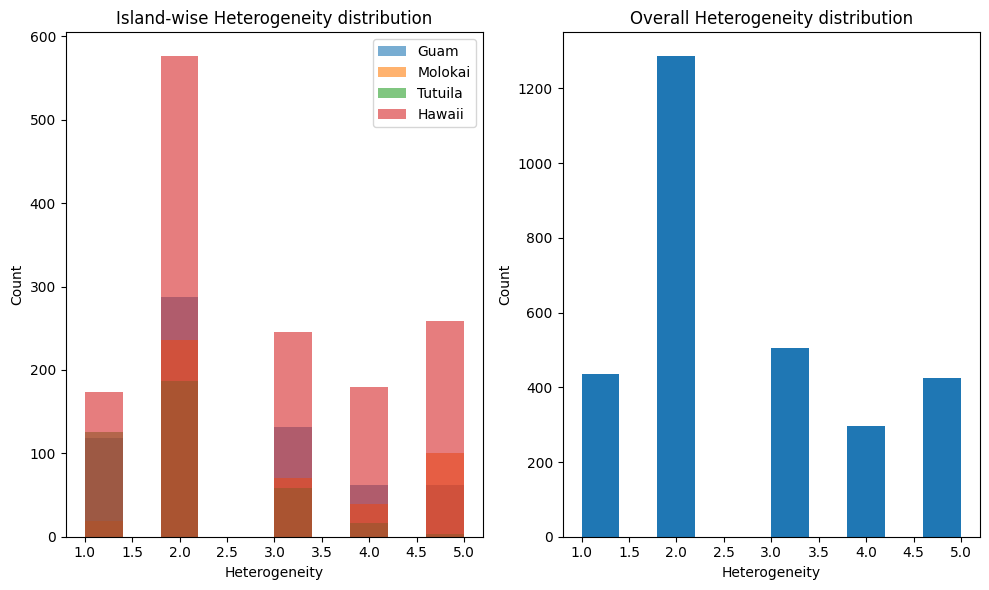

In [11]:
# example usage of the visualization functions
vis_rugosity('loc')
vis_rugosity('time')
vis_bleach('loc')

### Part II.b Coral Reef Biological Conditions Analysis
We analysis the coral reef biological conditions by investigating: fish density, juvenile size, taxon, etc.



In [12]:
def get_fish_data_visualization(stats='Mean', vis='Density', taxon=False, window=2):  
    ''' 
    function:def get_biomass_density_visualization(stats): 

    --> gets the scatterplot and statistical operation (mean or median) visulaizations of the biomass density per island. 
    --> gets the scatterplot and statistical operation (mean or median) visulaizations of the juvinile colony size per island. 
    --> gets the scatterplot and statistical operation (mean or median) visulaizations per each taxon if set. 

    example:
    --------
    >>>get_biomass_density_visualization('Mean') 
    (matplot graphs)
    
    param str stats: stats=='Mean' or stats=='Median' or stats=='Window' for the statistical operation to be performed. Default to 'Mean' 
    param str vis: Vis=='Density' or Vis=='Size' for type of visualization to obtain. Default to 'Density'  
    param bool taxon: Shows the statistics among each individual taxon per island when set to True. 
    param int window: Optional. Determine window size for a stats=='Window' operation

    returns: gets the scatterplot and statistical operation (mean or median) visulaizations of the biomass density per island. 
    '''
    assert stats=='Mean' or stats=='Median' or stats=='Window' or stats=='Scatter' #Did not enter either --> stats=='Mean' or stats=='Median' or stats=='Window' or stats=='Scatter'
    assert vis=='Density' or vis=='Size'    #Did not enter either --> vis=='Density' or vis=='Size'
    assert isinstance(taxon, bool)          #Did not enter --> a boolean value.
    assert isinstance(window,int) and window > 0

    for island in set(Data_Loader_biomass_density_change().get_df_time_fish_density()['Island']): #['Tutuila', 'Hawaii', 'Molokai', 'Guam']
        if taxon==False:
            if vis=='Density':
                #Biomass Density Dataframe overall
                vis_data_frame=Data_Loader_biomass_density_change().get_df_time_fish_density()   

                #Biomass Density Dataframe; Dates at specific island
                vis_data_frame_dates=vis_data_frame[vis_data_frame['Island']==island]['Start_Date']  

                #Biomass Density Dataframe, Densities at specific island
                vis_data_frame_vistype=vis_data_frame[vis_data_frame['Island']==island]['Density'] 

            elif vis=='Size':  

                #Size Stats only available for island of Molokai
                if island != 'Molokai': 
                    continue

                #Juvinile Colony Dataframe overall
                vis_data_frame=Data_Loader_biomass_density_change().get_df_time_juvenile_size()   
                
                #Juvinile Colony Dataframe; Dates at specific island
                vis_data_frame_dates=vis_data_frame[vis_data_frame['Island']==island]['Start_Date']  

                #Juvinile Colony Dataframe, Sizes at specific island
                vis_data_frame_vistype=vis_data_frame[vis_data_frame['Island']==island]['Size_mm']   
            
            else: 
                raise NotImplementedError   


            #Create Time axis by adding the year to the (month-1)/12 for sorting purposes
            time_axis=[int(str(date).split('-')[0])+(int(str(date).split('-')[1])-1)/12 for date in vis_data_frame_dates] 

            #Create density axis
            vistype_axis=[float(density) for density in vis_data_frame_vistype] 

            #Create Sorted Axes
            sorted_time_axis, sorted_vistype_axis=zip(*sorted(zip(time_axis,vistype_axis)))  

            #Create new dict for the purpose of condensing the multiple points on a single date
            stats_vistype_dict={}

            for x_y in sorted(zip(time_axis,vistype_axis)): 
                try: 
                    stats_vistype_dict[x_y[0]].append(x_y[1]) 
                except KeyError: 
                    stats_vistype_dict[x_y[0]]=[x_y[1]] 
            ''' 
            #shows the entire median_density_dict line per line.
            for key in median_density_dict: 
                print(f'{key}:{median_density_dict[key]}\n')

            #shows averages are the same
            print(biomass_density[(biomass_density['Island'] == 'Hawaii') & (biomass_density['Entered_Date'] == '2009-1')]['Density'].mean())
            print(st.mean(median_density_dict[2009.0]))
            '''  

            #perform the statistical operation
            if stats=='Mean':
                stats_vistype_time_axis, stats_density=zip(*[(key,st.mean(stats_vistype_dict[key])) for key in stats_vistype_dict])
            elif stats=='Median': 
                stats_vistype_time_axis, stats_density=zip(*[(key,st.median(stats_vistype_dict[key])) for key in stats_vistype_dict]) 
            elif stats=='Window': 
                stats_vistype_time_axis, stats_density=zip(*[(key,st.mean(stats_vistype_dict[key])) for key in stats_vistype_dict]) 
                stats_density=list(pd.DataFrame(stats_density,index=stats_vistype_time_axis).rolling(window).mean()[0]) 
            elif stats=='Scatter': 
                stats_vistype_time_axis, stats_density=zip(*[(key,st.mean(stats_vistype_dict[key])) for key in stats_vistype_dict])
            else: 
                raise NotImplementedError 

            #plot
            fig, (ax1, ax2) =plt.subplots( nrows=2, ncols=1, figsize=(10,8))
            
            ax1.set_title(f'Scatter Plot For Fish {vis} in {island} Since 2009')
            ax1.scatter(sorted_time_axis, sorted_vistype_axis)  
            ax1.set_xlabel('Years') 
            ax1.set_ylabel('Fish Density')

            ax2.set_title(f'{stats} For Fish {vis} in {island} Since 2009') 
            if stats!='Scatter':
                ax2.plot(stats_vistype_time_axis,stats_density)   
            elif stats=='Scatter': 
                ax2.scatter(stats_vistype_time_axis,stats_density) 
                a, b = np.polyfit(np.array(stats_vistype_time_axis), np.array(stats_density), 1)
                plt.plot(np.array(stats_vistype_time_axis), a*np.array(stats_vistype_time_axis)+b)
            else: 
                raise NotImplementedError

            ax2.set_xlabel('Years') 
            ax2.set_ylabel('Fish Density') 

            #plt.savefig(f'datavis/{stats}_{island}_{vis}.jpg')
            plt.tight_layout()
            plt.show()
        
        elif taxon==True: 
            data_per_taxon={} 
            
            for taxonomy in set(Data_Loader_biomass_density_change().get_df_time_fish_density()['Type']):#{'Invert', 'Algae', 'Fish', 'Coral'}
                
                if vis=='Density':
                    #Biomass Density Dataframe overall
                    vis_data_frame=Data_Loader_biomass_density_change().get_df_time_fish_density()   

                    #Biomass Density Dataframe; Dates at specific island
                    vis_data_frame_dates=vis_data_frame[(vis_data_frame['Island']==island) & (vis_data_frame['Type']==taxonomy)]['Start_Date']  
                    
                    #Biomass Density Dataframe, Densities at specific island
                    vis_data_frame_vistype=vis_data_frame[(vis_data_frame['Island']==island) & (vis_data_frame['Type']==taxonomy)]['Density'] 
                    
                elif vis=='Size':  

                    #Size Stats only available for island of Molokai
                    if island != 'Molokai' or taxonomy !='Coral': 
                        continue

                    #Juvinile Colony Dataframe overall
                    vis_data_frame=Data_Loader_biomass_density_change().get_df_time_juvenile_size()   
                    
                    #Juvinile Colony Dataframe; Dates at specific island
                    vis_data_frame_dates=vis_data_frame[(vis_data_frame['Island']==island) & (vis_data_frame['Type']==taxonomy)]['Start_Date']  
                    #Juvinile Colony Dataframe, Sizes at specific island
                    vis_data_frame_vistype=vis_data_frame[(vis_data_frame['Island']==island) & (vis_data_frame['Type']==taxonomy)]['Size_mm']   
                
                else: 
                    raise NotImplementedError  
                #Create Time axis by adding the year to the (month-1)/12 for sorting purposes
                time_axis=[int(str(date).split('-')[0])+(int(str(date).split('-')[1])-1)/12 for date in vis_data_frame_dates] 
                
                #Create density axis
                vistype_axis=[float(density) for density in vis_data_frame_vistype] 
                
                if len(time_axis)==0 or len(vistype_axis)==0: #seems like some taxon types do not have data associated with them. 
                    #this print statement shows this is the case.
                    #print(f"{taxonomy}:{len(vis_data_frame[(vis_data_frame['Island']==island) & (vis_data_frame['Type']==taxonomy)]['Start_Date'])}")
                    continue 

                #Create Sorted Axes
                sorted_time_axis, sorted_vistype_axis=zip(*sorted(zip(time_axis,vistype_axis)))  

                #Create new dict for the purpose of condensing the multiple points on a single date
                stats_vistype_dict={}

                for x_y in sorted(zip(time_axis,vistype_axis)): 
                    try: 
                        stats_vistype_dict[x_y[0]].append(x_y[1]) 
                    except KeyError: 
                        stats_vistype_dict[x_y[0]]=[x_y[1]] 

                if stats=='Mean':
                    stats_vistype_time_axis, stats_density=zip(*[(key,st.mean(stats_vistype_dict[key])) for key in stats_vistype_dict])
                elif stats=='Median': 
                    stats_vistype_time_axis, stats_density=zip(*[(key,st.median(stats_vistype_dict[key])) for key in stats_vistype_dict])  
                elif stats=='Window': 
                    stats_vistype_time_axis, stats_density=zip(*[(key,st.mean(stats_vistype_dict[key])) for key in stats_vistype_dict]) 
                    stats_density=list(pd.DataFrame(stats_density,index=stats_vistype_time_axis).rolling(window).mean()[0]) 
                elif stats=='Scatter': 
                    stats_vistype_time_axis, stats_density=zip(*[(key,st.mean(stats_vistype_dict[key])) for key in stats_vistype_dict])
                else: 
                    raise NotImplementedError  
                
                data_per_taxon[taxonomy]={'sorted_time_axis':sorted_time_axis,  
                                       'sorted_vistype_axis':sorted_vistype_axis,  
                                       'stats_vistype_time_axis':stats_vistype_time_axis, 
                                       'stats_density':stats_density}  
            
            if len(data_per_taxon) != 0: #mainly for the vis='Size' operation since there is only data for one island.
                fig, ax =plt.subplots( nrows=2, ncols=4, figsize=(10,8))
                
                for index, key in enumerate(data_per_taxon): 
                    ax[0,index].set_title(f'{key}')
                    ax[0,index].scatter(data_per_taxon[key]['sorted_time_axis'], data_per_taxon[key]['sorted_vistype_axis'])  
                    ax[0,index].set_xlabel('Years') 
                    ax[0,index].set_ylabel('Fish Density')

                    if stats != 'Scatter':
                        ax[1,index].plot(data_per_taxon[key]['stats_vistype_time_axis'],data_per_taxon[key]['stats_density']) 
                        ax[1,index].set_xlabel('Years') 
                        ax[1,index].set_ylabel('Fish Density')  
                    elif stats=='Scatter':  
                        ax[1,index].scatter(data_per_taxon[key]['stats_vistype_time_axis'],data_per_taxon[key]['stats_density']) 
                        a, b = np.polyfit(np.array(data_per_taxon[key]['stats_vistype_time_axis']), np.array(data_per_taxon[key]['stats_density']), 1)
                        ax[1,index].plot(np.array(data_per_taxon[key]['stats_vistype_time_axis']), a*np.array(data_per_taxon[key]['stats_vistype_time_axis'])+b) 
                        ax[1,index].set_xlabel('Years') 
                        ax[1,index].set_ylabel('Fish Density')  
                        

                fig.suptitle(f'Scatter Plot and {stats} For {key} {vis} in {island} Since 2009', fontsize=16)
                
                plt.tight_layout()
                plt.show()  

def get_taxon_piechart(vis='Density'): 
    ''' 
        Function: get_taxon_piechart(vis='Density'):  

        --> Gets the top 10 most common genus accross all islands at once, individually and alltogether. 

        example:
        --------
        >>>get_taxon_piechart():
        (matplot graphs)
         
        param str vis: vis=='Density' or vis=='Size' for type of visualization to obtain. Default to 'Density'  

        returns: Gets the top 10 most common genus accross all islands at once, individually and alltogether. 
    ''' 
    for island in set(Data_Loader_biomass_density_change().get_df_time_fish_density()['Island']): #['Tutuila', 'Hawaii', 'Molokai', 'Guam']
        if vis=='Density':
            #Biomass Density Dataframe overall
            vis_data_frame=Data_Loader_biomass_density_change().get_df_time_fish_density()   

            #Biomass Density Dataframe, Densities at specific island
            vis_data_frame_vistype=vis_data_frame[vis_data_frame['Island']==island]['Taxon_Name']  
            

        elif vis=='Size':  

            #Size Stats only available for island of Molokai
            if island != 'Molokai': 
                continue

            #Juvinile Colony Dataframe overall
            vis_data_frame=Data_Loader_biomass_density_change().get_df_time_juvenile_size()   

            #Juvinile Colony Dataframe, Sizes at specific island
            vis_data_frame_vistype=vis_data_frame[vis_data_frame['Island']==island]['Taxon_Name']   
            
        else: 
            raise NotImplementedError 
        fish_df_raw=pd.DataFrame({'fish':[name.split()[0] for name in vis_data_frame_vistype]}).value_counts() 
        fish_df_raw=pd.DataFrame({'fish':fish_df_raw.index, 'counts':fish_df_raw.values}) 
        fish_df=pd.DataFrame({'fish':fish_df_raw['fish'].apply(lambda x: x[0]),'counts':100*(fish_df_raw['counts']/fish_df_raw['counts'].sum())}).head(5) 
        
        fish_df_2=pd.DataFrame({'fish':['Other'],'counts':[100-fish_df['counts'].sum()]})  
        print(fish_df_2)
        fish_df=pd.concat([fish_df,fish_df_2]) 
        
        fig, ax = plt.subplots() 
        explode=[0 for i in range(len(fish_df))] 
        explode[0]=0.3 

        ax.pie(fish_df['counts'], labels=fish_df['fish'], autopct='%1.1f%%',explode=explode) 
        ax.set_title(f'Frequency of Genus on {island}')
        
        #plt.savefig(f'piecharts/{island}.jpg')
        plt.tight_layout()
        plt.show()

    fish_df_raw=pd.DataFrame({'fish':[name.split()[0] for name in vis_data_frame['Taxon_Name']]}).value_counts() 
    fish_df_raw=pd.DataFrame({'fish':fish_df_raw.index, 'counts':fish_df_raw.values}) 
    fish_df=pd.DataFrame({'fish':fish_df_raw['fish'].apply(lambda x: x[0]),'counts':100*(fish_df_raw['counts']/fish_df_raw['counts'].sum())}).head(5) 
    
    fish_df_2=pd.DataFrame({'fish':['Other'],'counts':[100-fish_df['counts'].sum()]})  
    print(fish_df_2)
    fish_df=pd.concat([fish_df,fish_df_2]) 
    
    fig, ax = plt.subplots() 
    explode=[0 for i in range(len(fish_df))] 
    explode[0]=0.3 

    ax.pie(fish_df['counts'], labels=fish_df['fish'], autopct='%1.1f%%',explode=explode) 
    ax.set_title(f'Frequency of Genus Overall')
    
    #plt.savefig(f'piecharts/all_islands.jpg')
    plt.tight_layout()
    plt.show()    

def get_taxon_over_time(vis='Density'): 
    ''' 
        Function: get_taxon_over_time(vis='Density'):  

        --> gets the top 10 most common genus per year per island in percents. 

        example:
        --------
        >>>get_taxon_over_time(vis='Density') 
        (matplot graphs)
         
        param str vis: Vis=='Density' or Vis=='Size' for type of visualization to obtain. Default to 'Density'  

        returns: gets the top 10 most common genus per year per island in percents. 
    '''

    for island in set(Data_Loader_biomass_density_change().get_df_time_fish_density()['Island']): #['Tutuila', 'Hawaii', 'Molokai', 'Guam']
        
        if vis=='Density':
            #Biomass Density Dataframe overall
            vis_data_frame=Data_Loader_biomass_density_change().get_df_time_fish_density()   

            #Biomass Density Dataframe; Dates at specific island
            vis_data_frame_dates=vis_data_frame[(vis_data_frame['Island']==island)]['Start_Date']  
            
            #Biomass Density Dataframe, Densities at specific island
            vis_data_frame_vistype=vis_data_frame[(vis_data_frame['Island']==island)]['Taxon_Name']            
            
             
        elif vis=='Size':  

            #Size Stats only available for island of Molokai
            if island != 'Molokai': 
                continue

            #Juvinile Colony Dataframe overall
            vis_data_frame=Data_Loader_biomass_density_change().get_df_time_juvenile_size()   
            
            #Juvinile Colony Dataframe; Dates at specific island
            vis_data_frame_dates=vis_data_frame[(vis_data_frame['Island']==island)]['Start_Date']  
            #Juvinile Colony Dataframe, Sizes at specific island
            vis_data_frame_vistype=vis_data_frame[(vis_data_frame['Island']==island)]['Taxon_Name']   
            
        
        else: 
            raise NotImplementedError  
        
        

        time_axis=[int(str(date).split('-')[0]) for date in vis_data_frame_dates]  
        
        #creates a dict where the keys are the year, and the values are arrays that contain the genus that was recorded that year.
        taxon_breakdown_per_date_names={}
        for date_fish in zip(time_axis,list(vis_data_frame_vistype)): 
            try: 
                taxon_breakdown_per_date_names[date_fish[0]].append(date_fish[1].split()[0]) 
            except KeyError: 
                taxon_breakdown_per_date_names[date_fish[0]]=[date_fish[1].split()[0]]  

        #creates a dict where the keys are the year and the values are dicts, where the keys are the genus, and the values are percentage of times it appears.
        taxon_breakdown_per_date_numbers={}
        for key in taxon_breakdown_per_date_names: 
            breakdown_per_taxon={} 
            for taxon_name in vis_data_frame_vistype.unique():  
                if taxon_name.split()[0] in taxon_breakdown_per_date_names[key]:
                    breakdown_per_taxon[taxon_name.split()[0]]=(((pd.Series(taxon_breakdown_per_date_names[key])==taxon_name.split()[0]).sum()/len(taxon_breakdown_per_date_names[key]))*100) 
                else: 
                    breakdown_per_taxon[taxon_name.split()[0]]=0
            taxon_breakdown_per_date_numbers[key]=breakdown_per_taxon    
        
          
        #undicts the taxon_breakdown_per_date_numbers and separate sthem into lists of date, genus, and percents.
        taxon_breakdown_per_date_list=sorted([(key, 
                                        list(taxon_breakdown_per_date_numbers[key].keys()),  
                                        list(taxon_breakdown_per_date_numbers[key].values())) for key in taxon_breakdown_per_date_numbers])
            
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_title('Animated Fish Quantities per Date')
        ax.set_ylabel('Fish Types')
        ax.set_xlabel('Quantity')
        
        #for loop that generates the animation for top 10 most common genus per year.
        for i in range(len(taxon_breakdown_per_date_list)):
            #print(f'{taxon_breakdown_per_date_list[i][0]} : {max(zip(taxon_breakdown_per_date_list[i][2],taxon_breakdown_per_date_list[i][1]))} ')
            #'''
            ax.set_title(f'10 Most Common Genus on {island} \n {(int(taxon_breakdown_per_date_list[i][0]))}')
            ax.set_ylabel('Fish Genus')
           
            

            # Plot the animated histogram 
            fish_df=pd.DataFrame({'fish':taxon_breakdown_per_date_list[i][1],'quantity':taxon_breakdown_per_date_list[i][2]}).sort_values(by='quantity')
            
            fish_mode=str(pd.Series([name.split()[0] for name in vis_data_frame['Taxon_Name']]).mode()[0])  
            non_highlight_color='#768493' 
            highlight_color='#1f77b4'

            fish_df['colors']=fish_df['fish'].apply(lambda x: highlight_color if str(x) == fish_mode else non_highlight_color)  
            bars=plt.barh(fish_df.tail(10)['fish'],fish_df.tail(10)['quantity'],height=0.8,color=fish_df.tail(10)['colors'])  
            
            ax.spines[['right','bottom','top']].set_visible(False) 
            ax.xaxis.set_visible(False) 
            ax.bar_label(bars, padding=-45, color='white',fontsize=10,label_type='edge',fmt='%.1f%%',fontweight='bold')
            #plt.tight_layout
            plt.xlim(0, 30) 
            plt.legend(handles=[Patch(facecolor="#1f77b4", label="Most Frequently Appearing Genus Since 2009")],loc='lower right')
            plt.yticks(fontsize=10)  # Set a smaller font size for y-axis labels
            plt.subplots_adjust(left=0.2)  # Adjust the left margin
            plt.draw()  
            #plt.savefig(f'taxon_time/Taxon_{island}_frame_{i}.jpg') USE THIS TO SAVE EACH FIGURE
            plt.pause(0.3) 
            ax.cla()
            #'''
        plt.close()

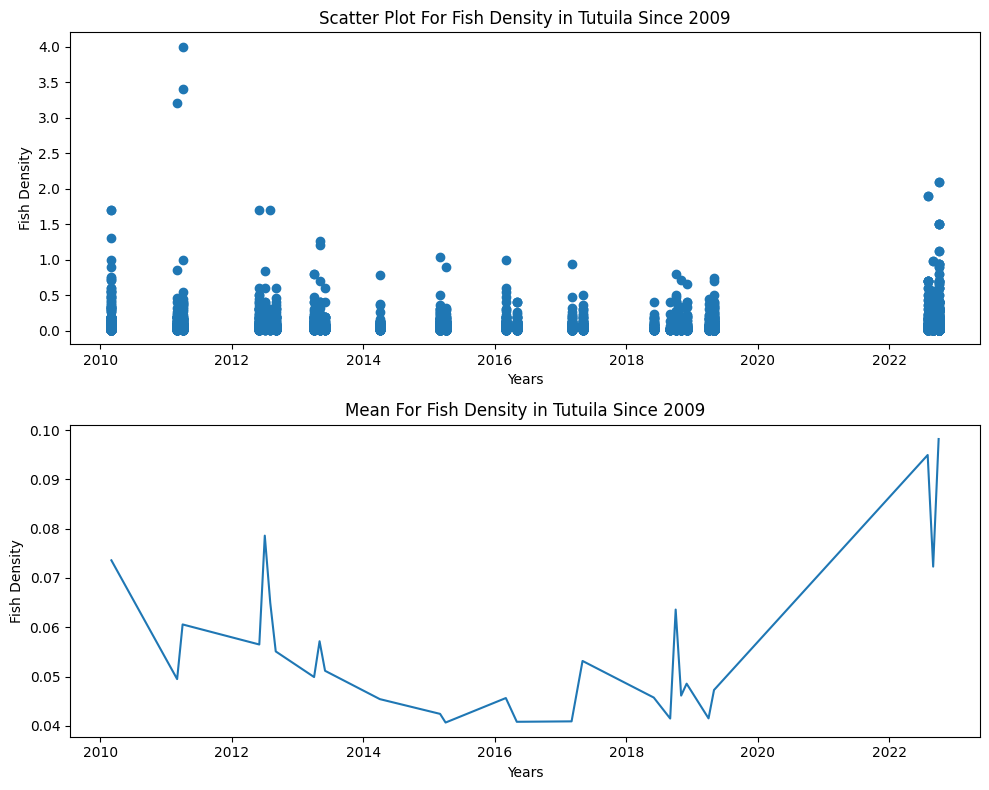

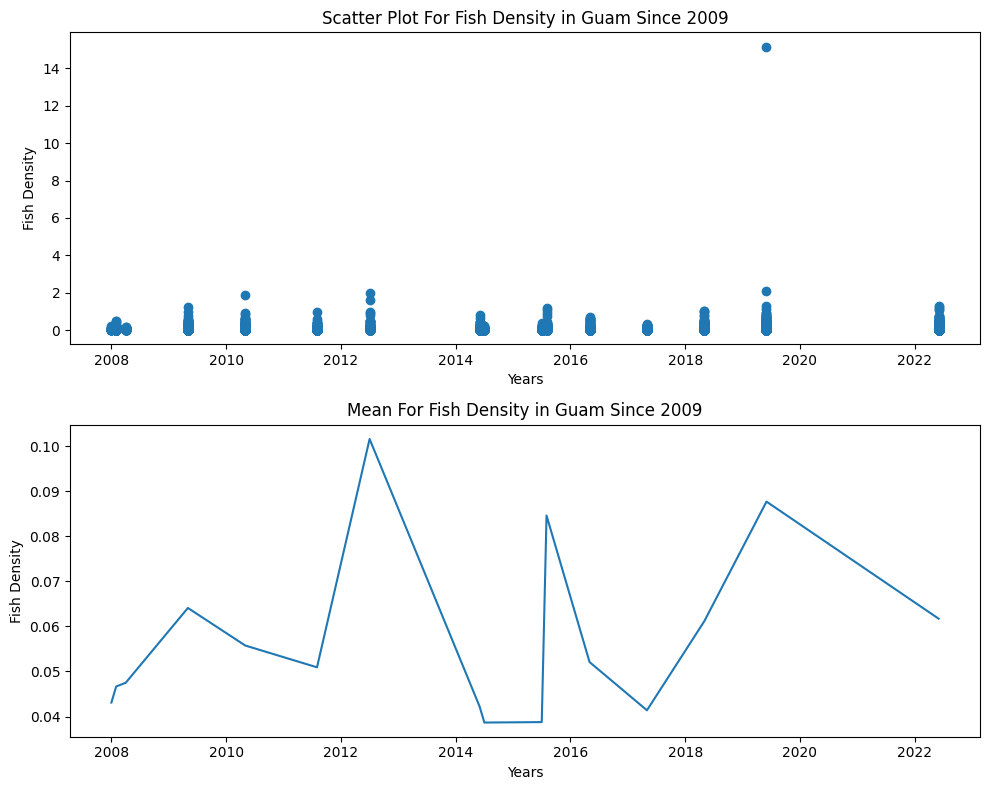

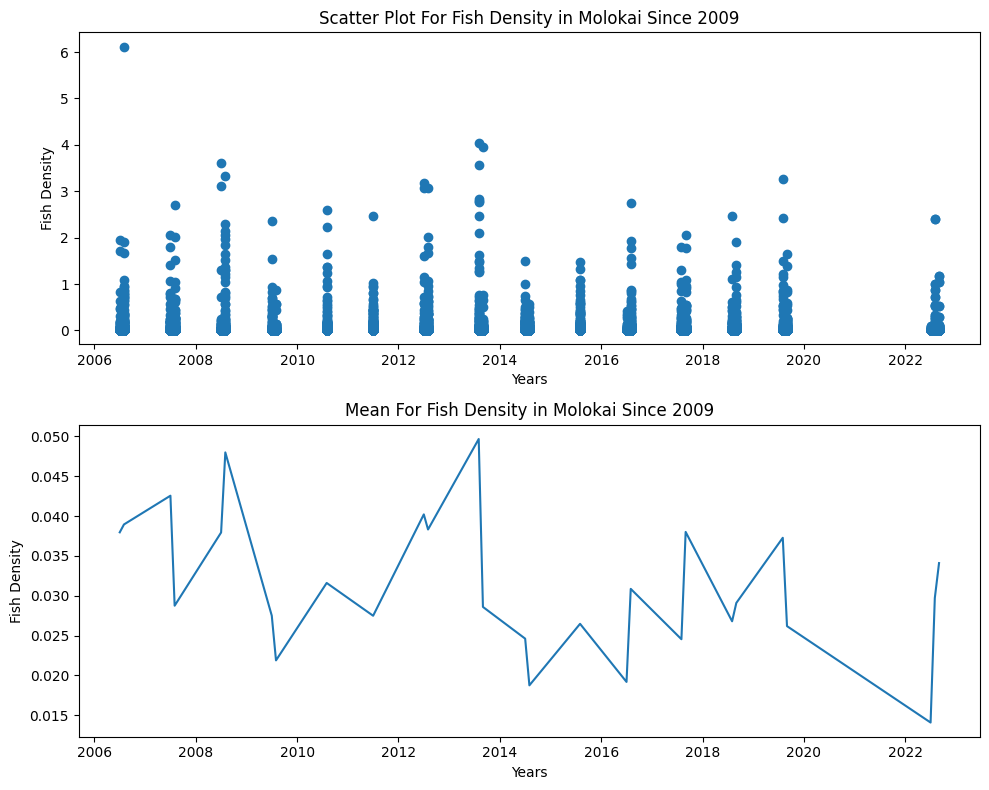

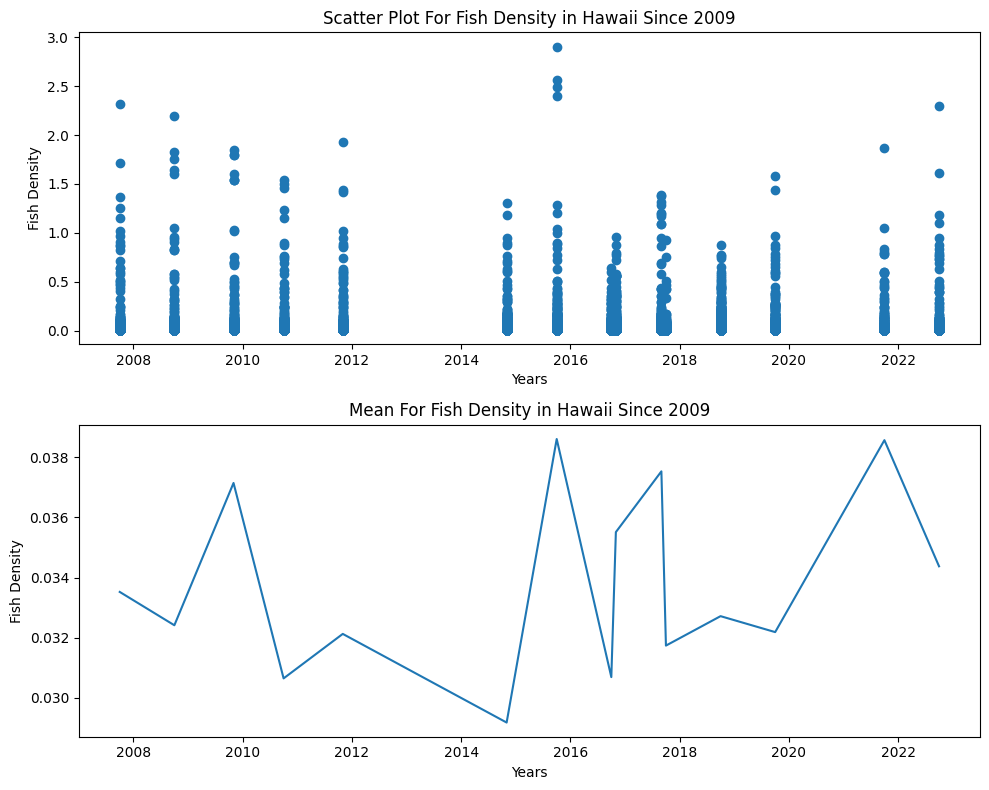

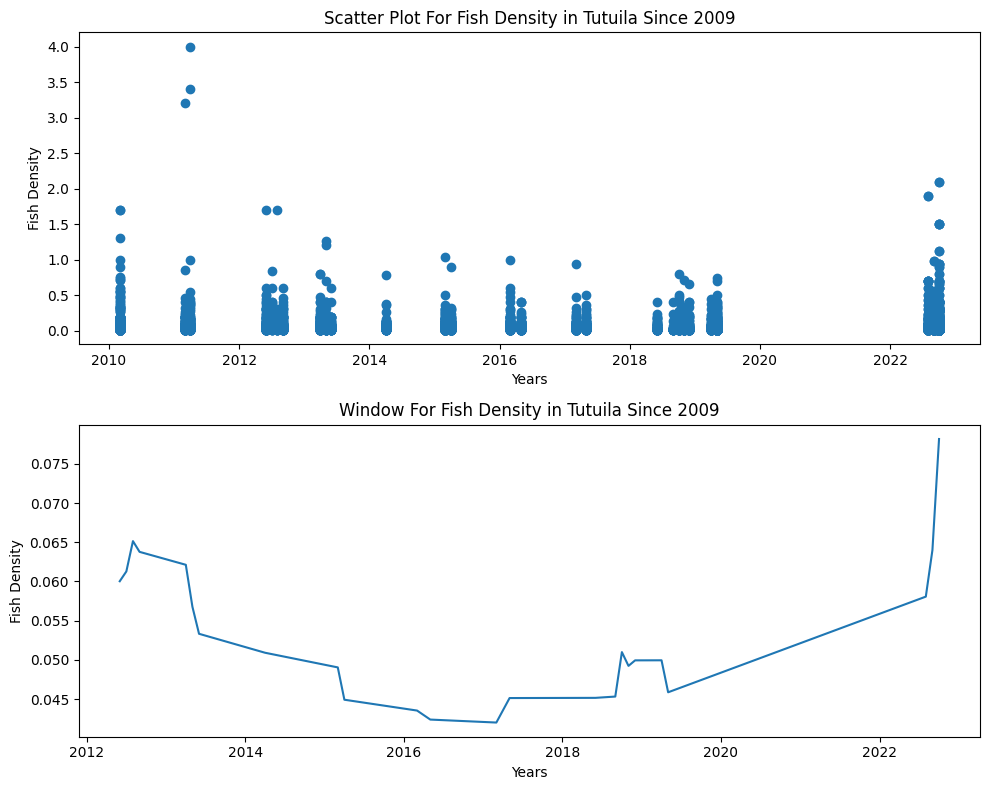

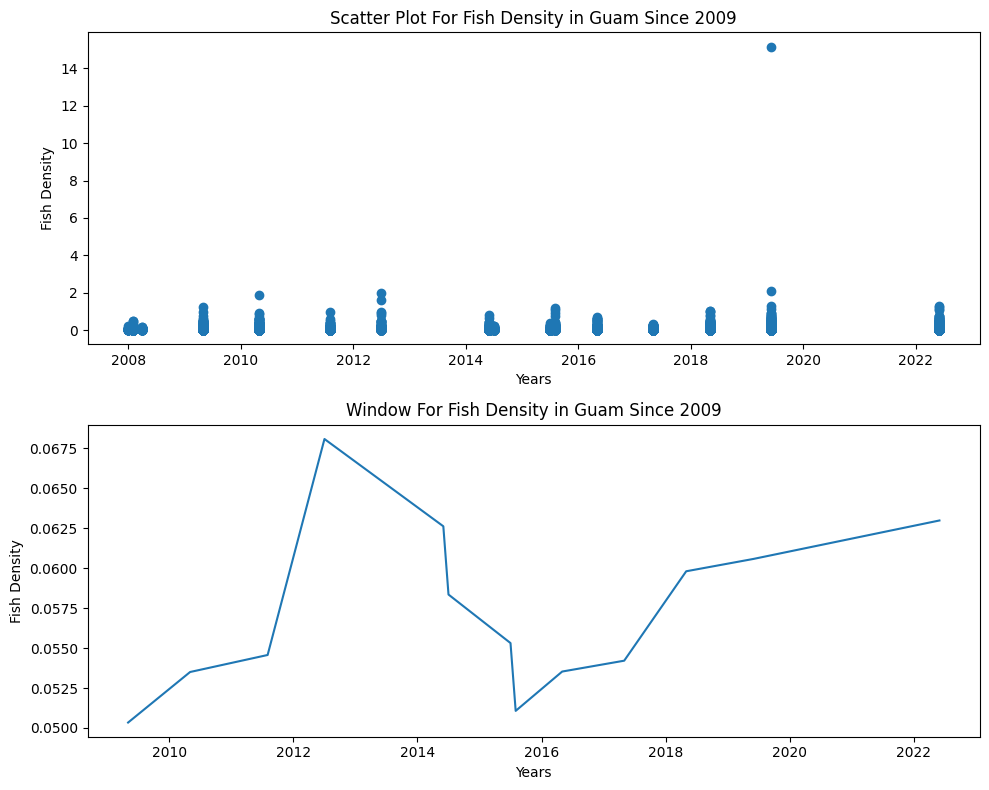

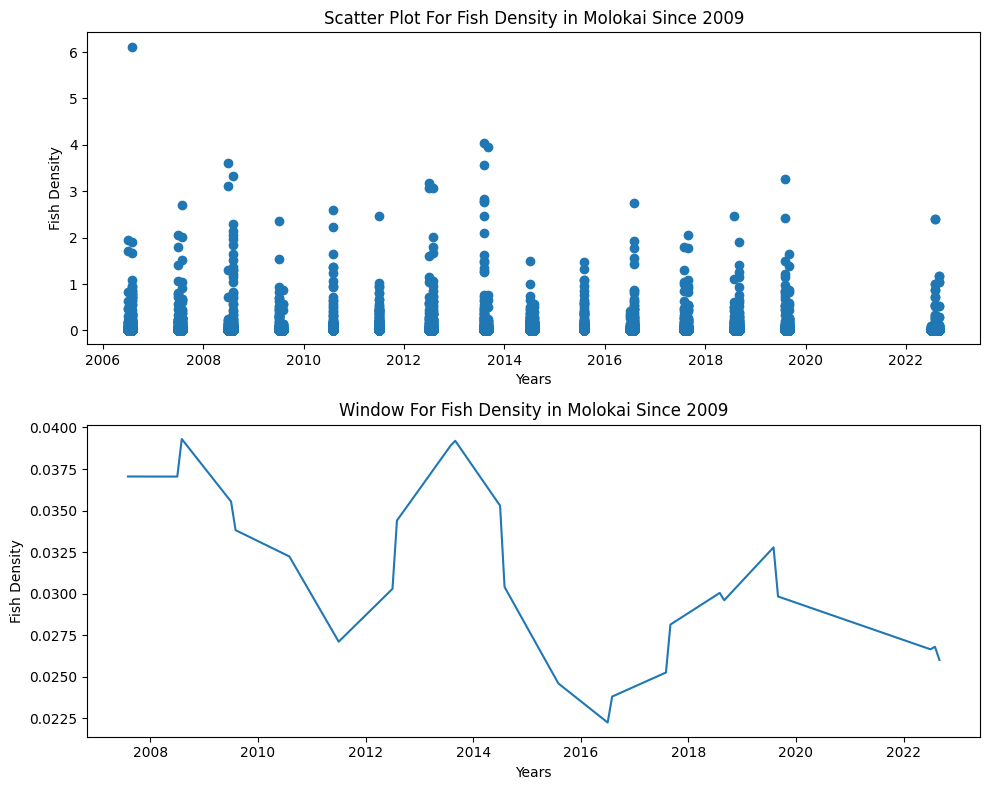

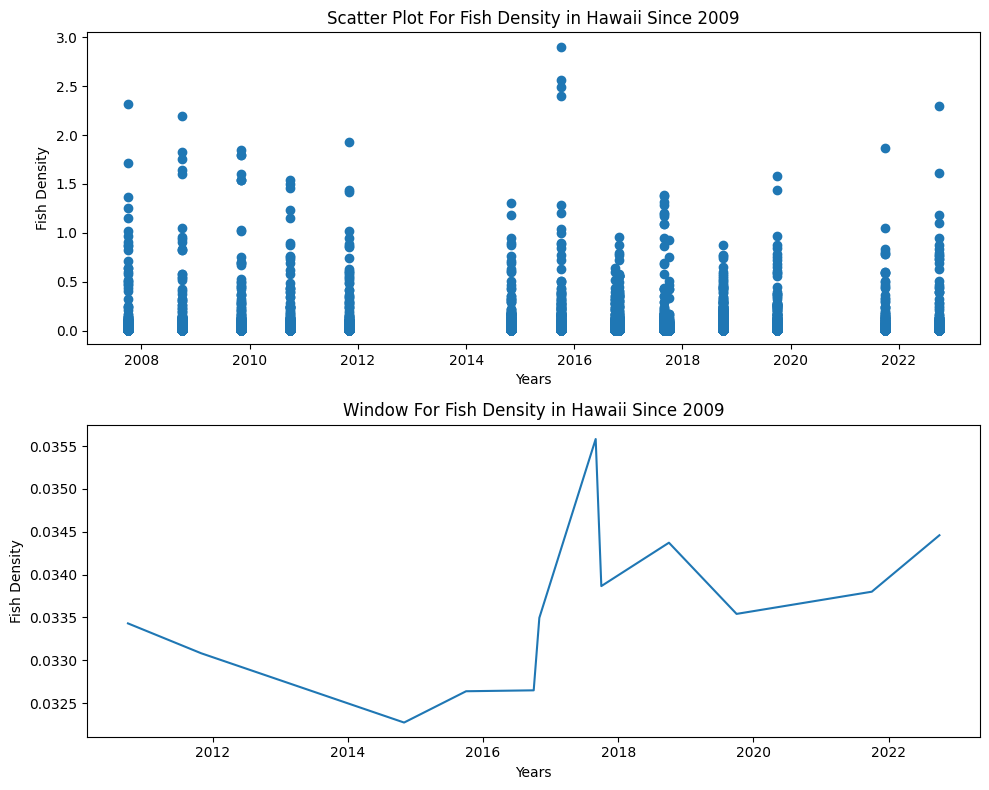

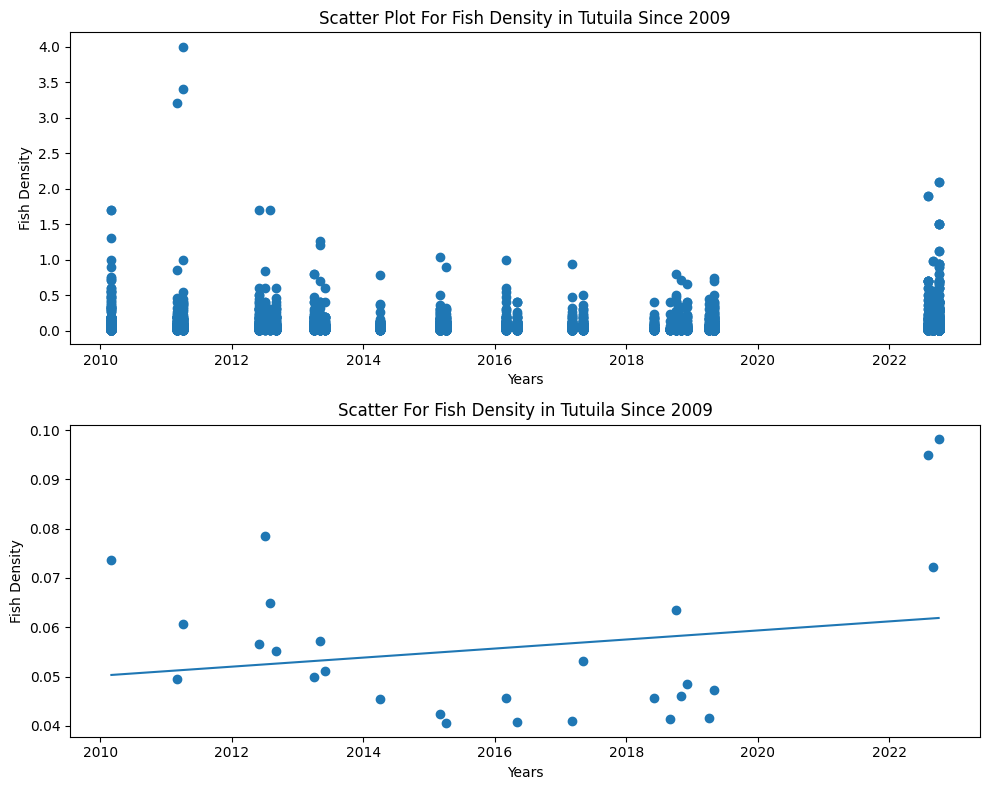

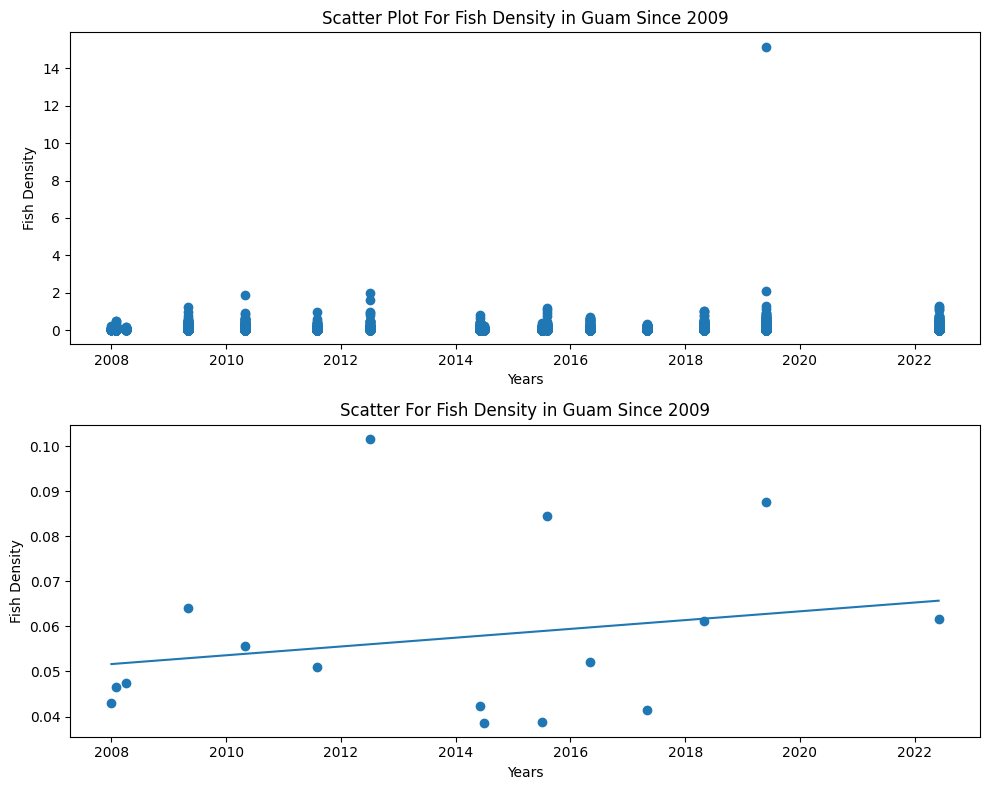

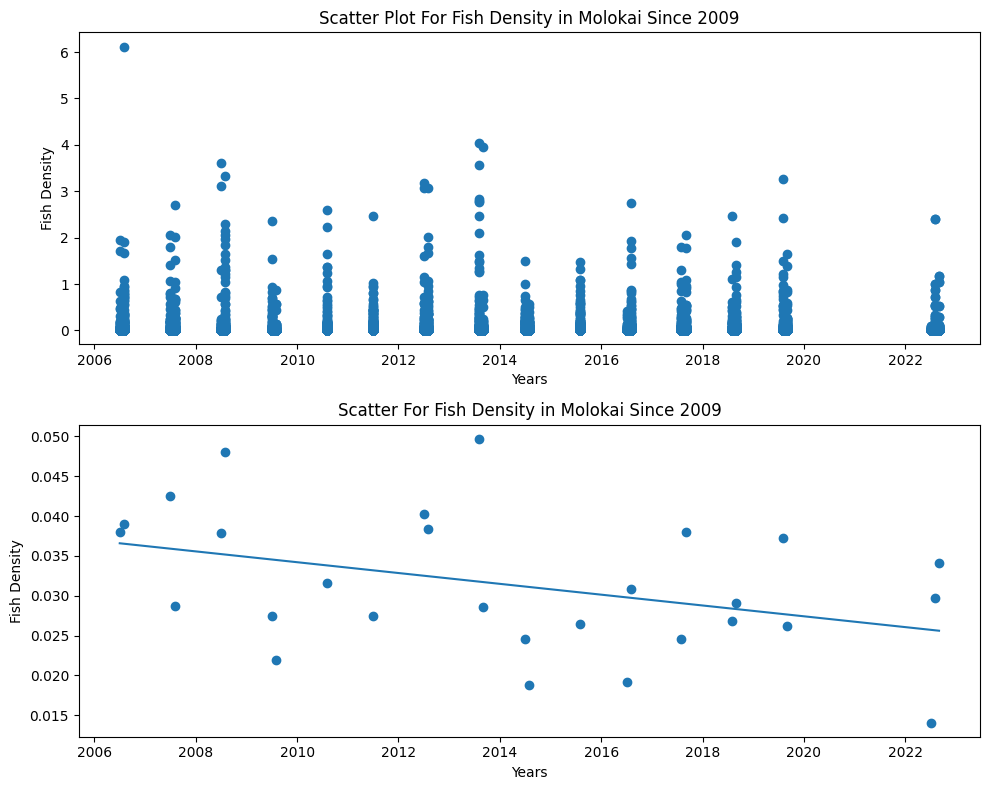

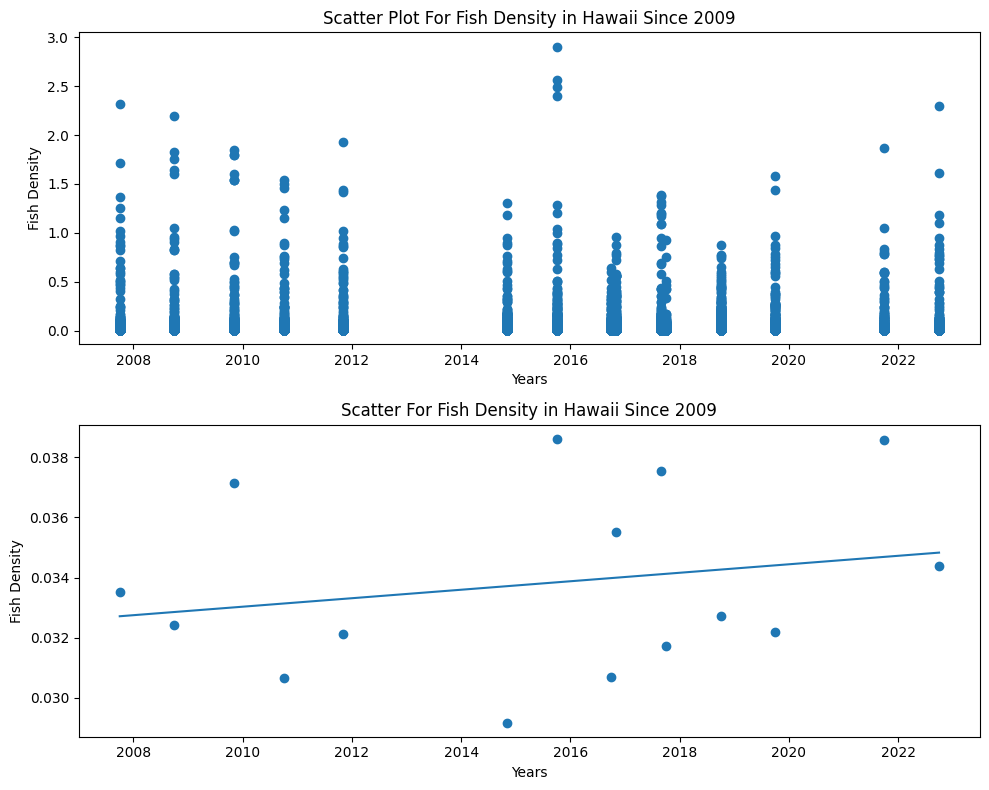

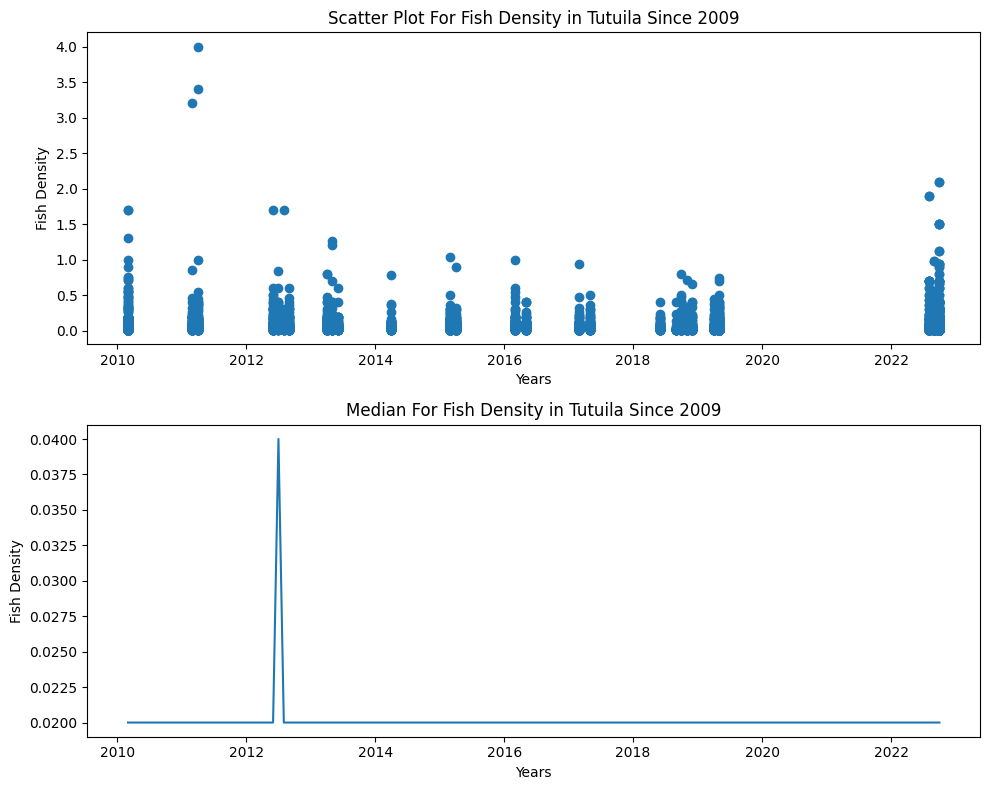

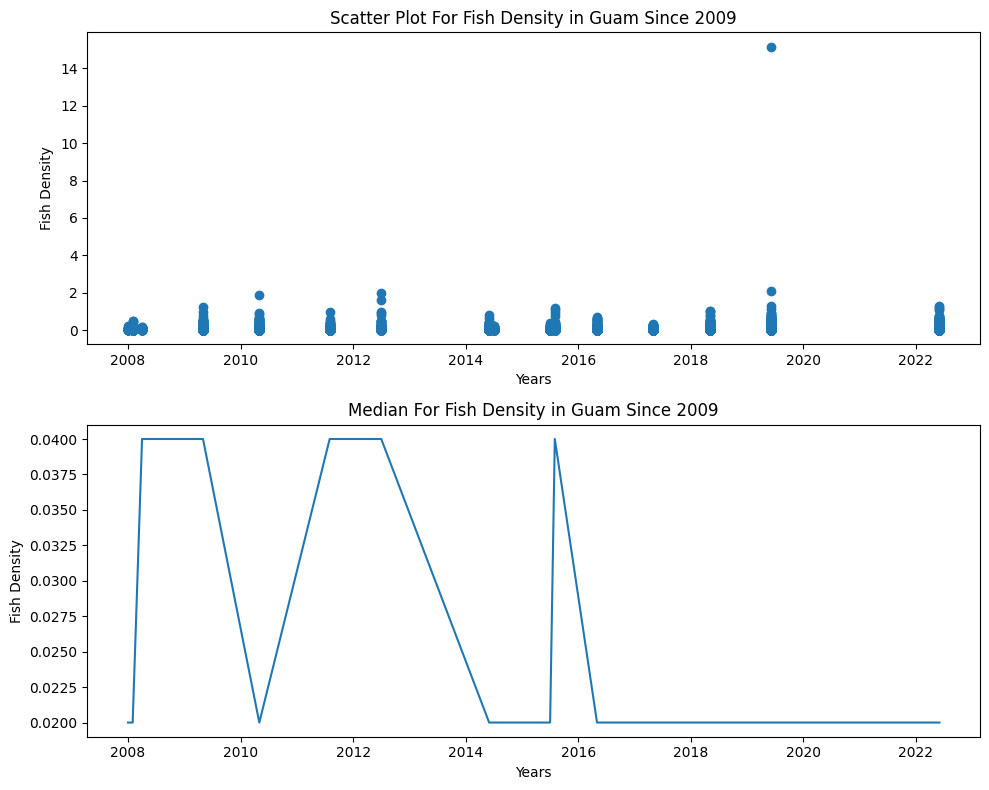

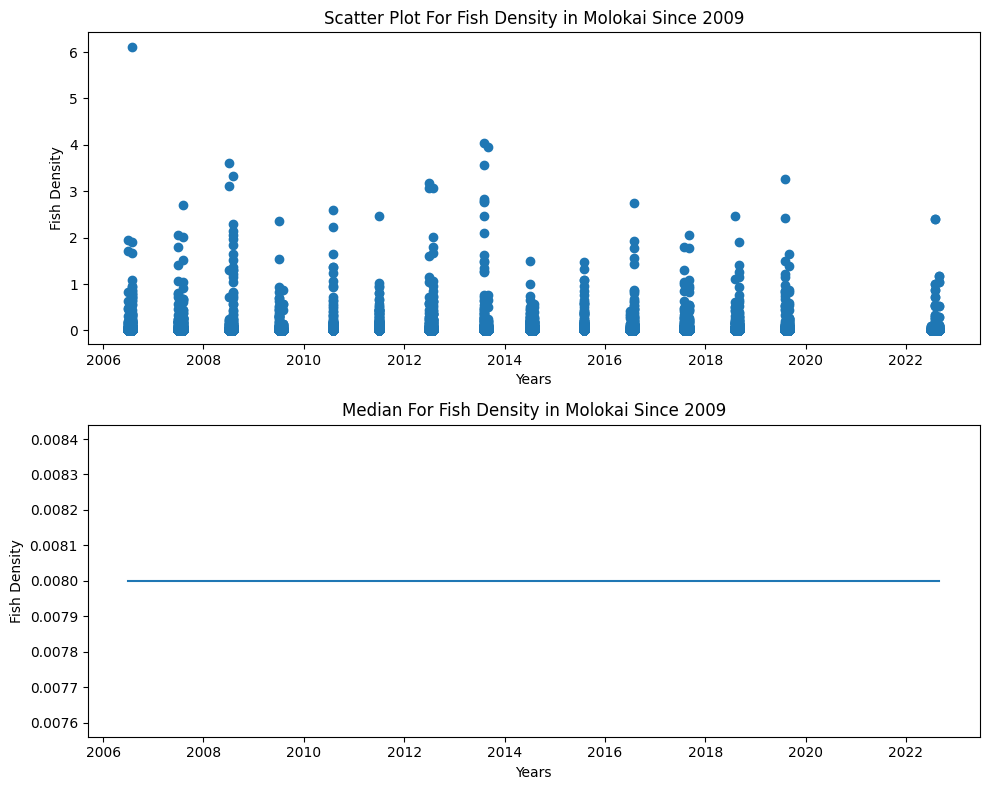

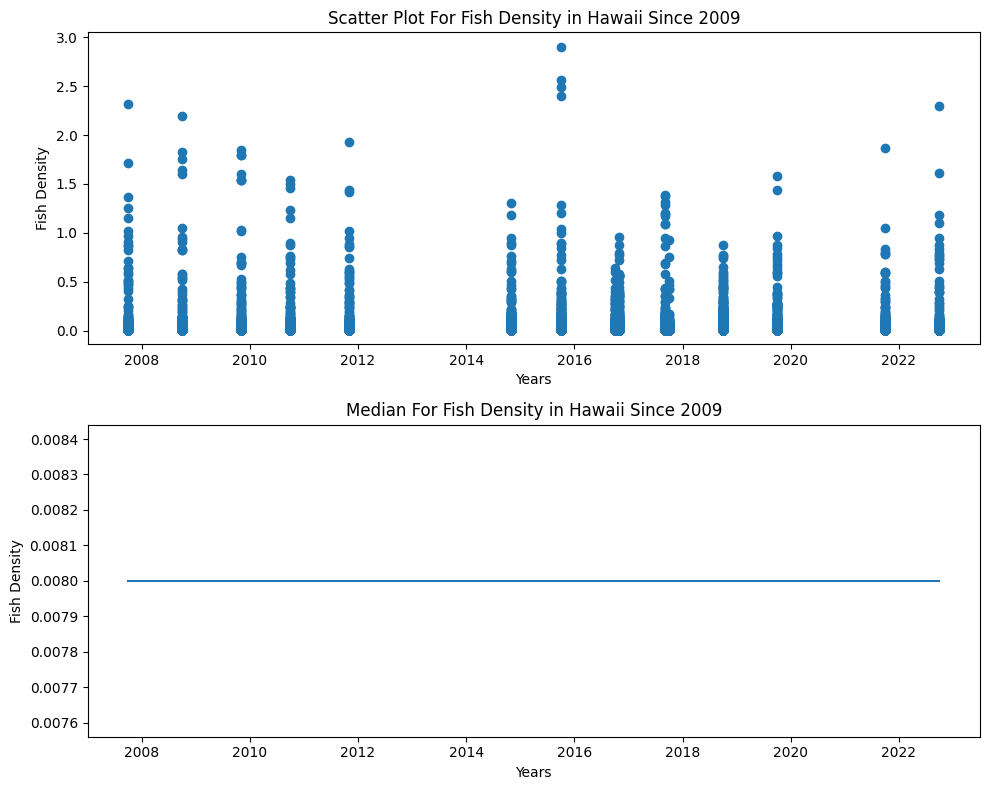

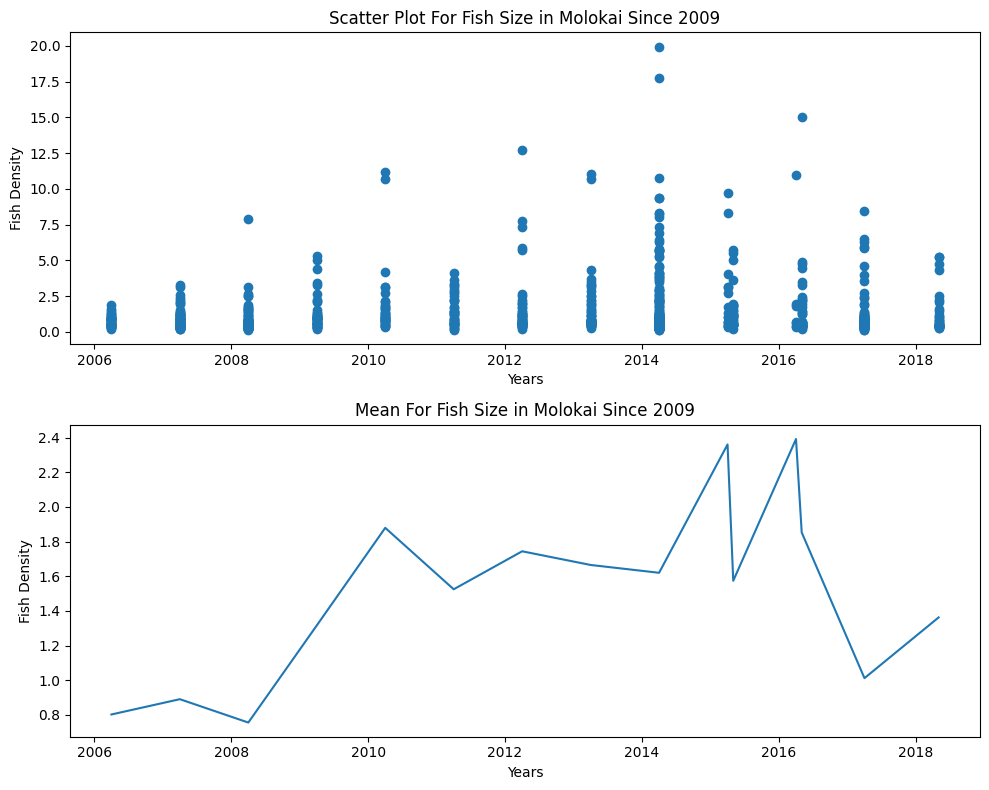

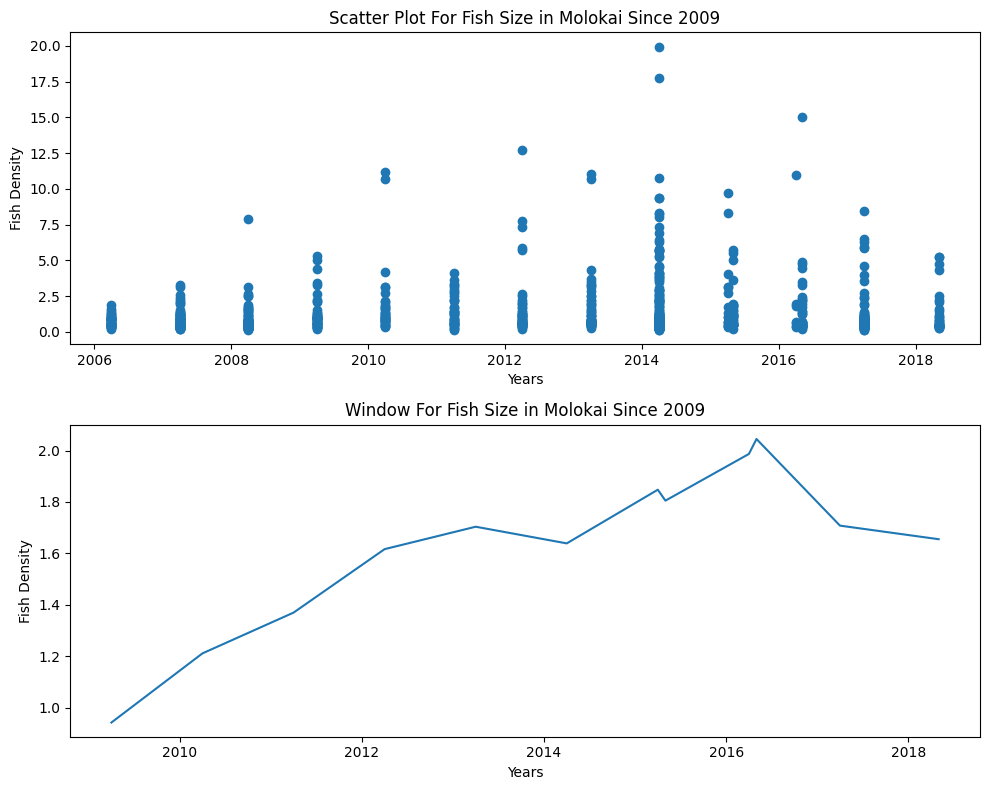

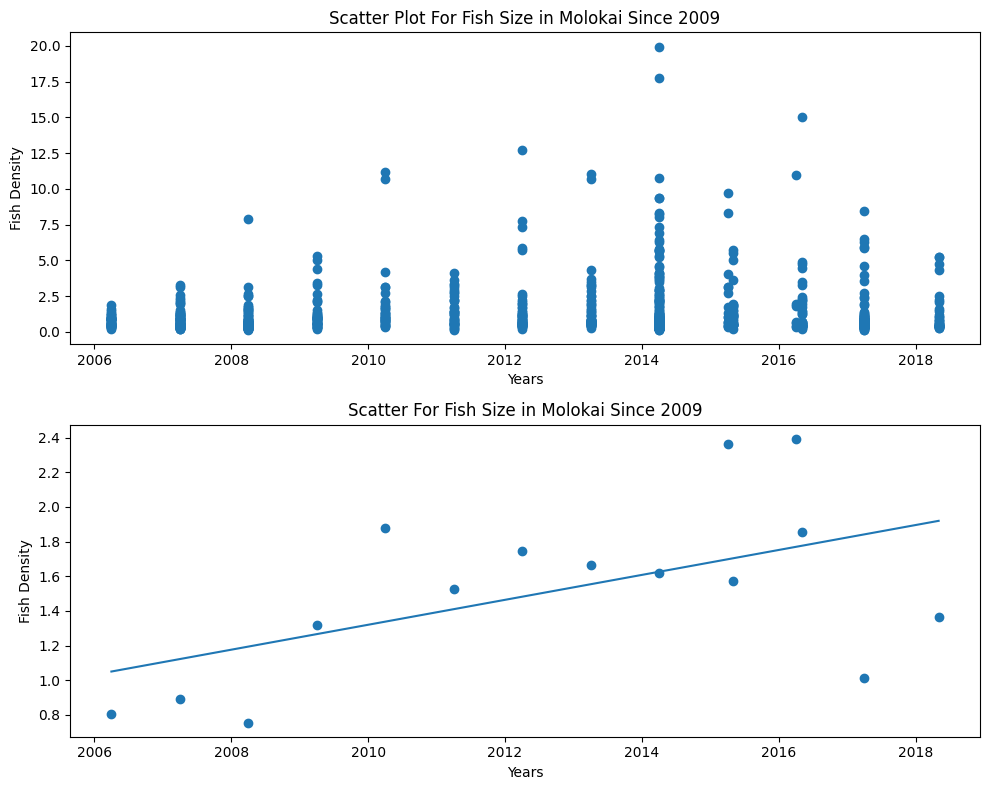

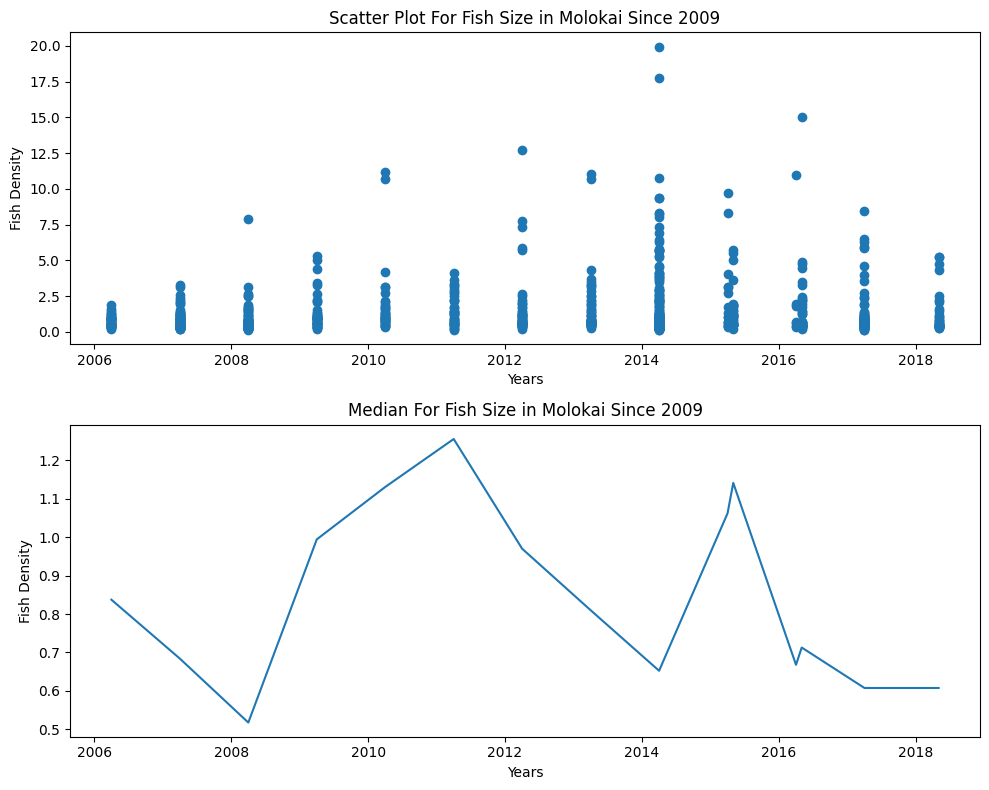

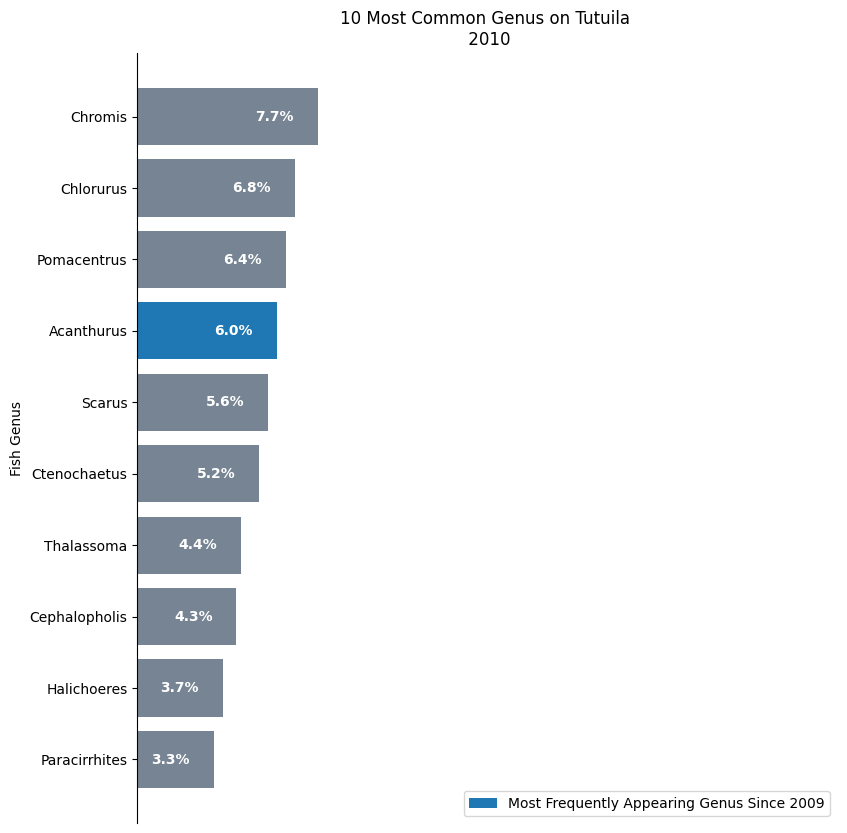

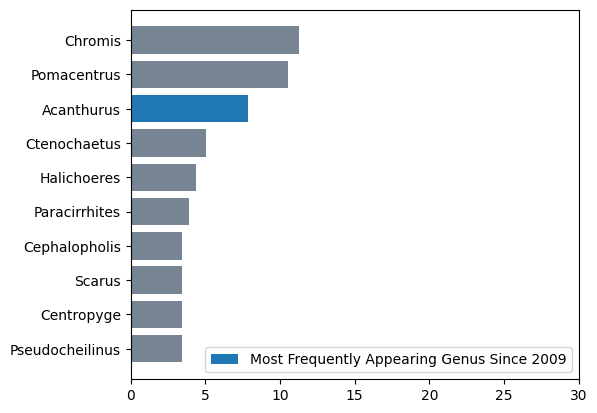

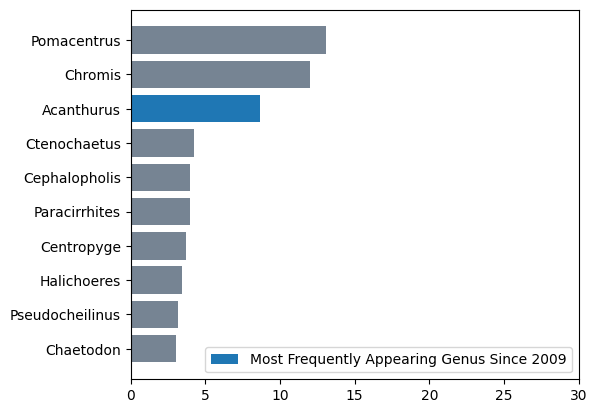

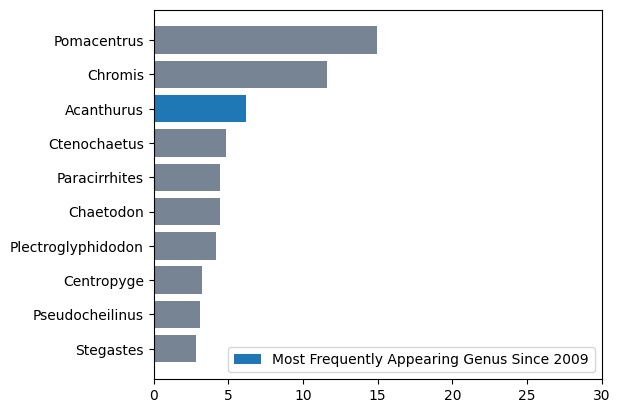

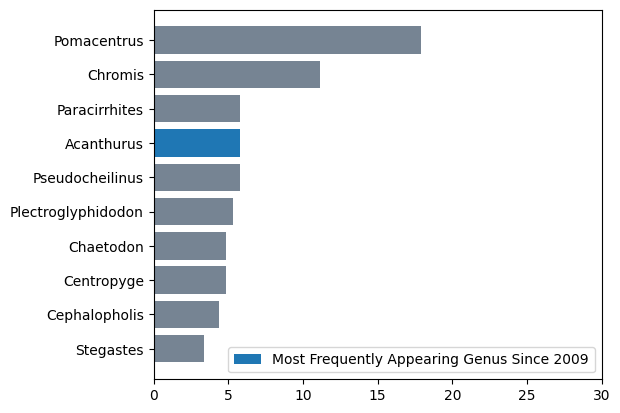

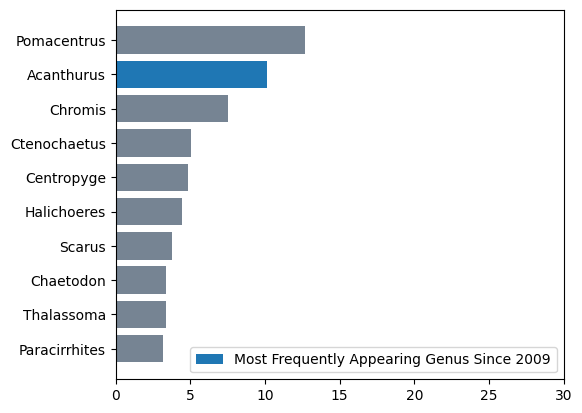

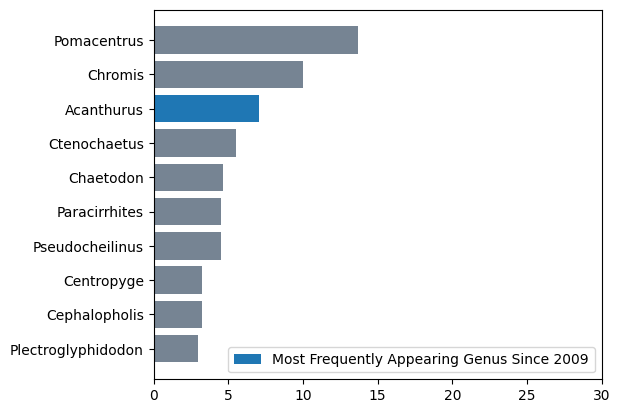

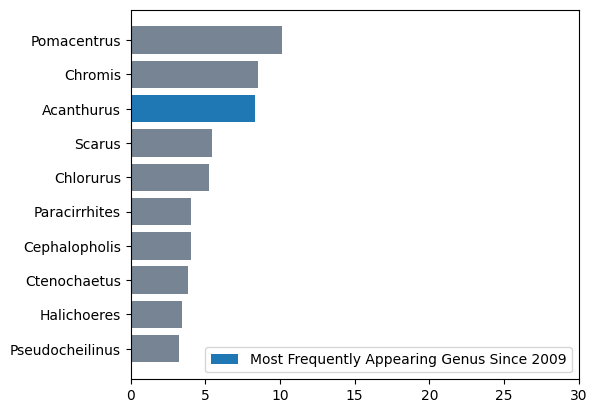

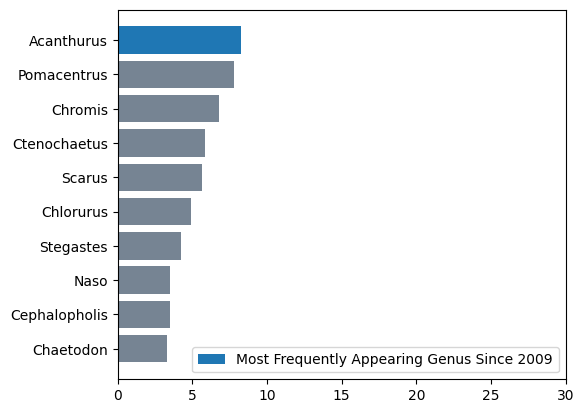

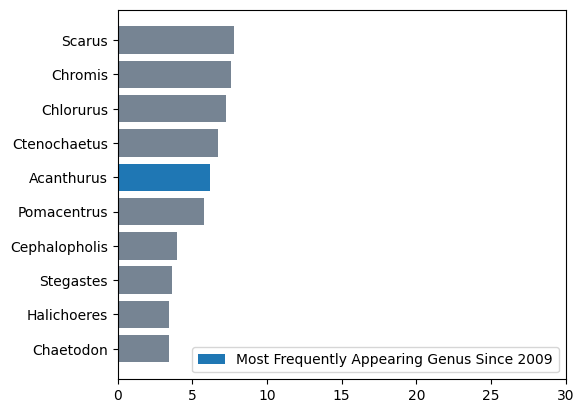

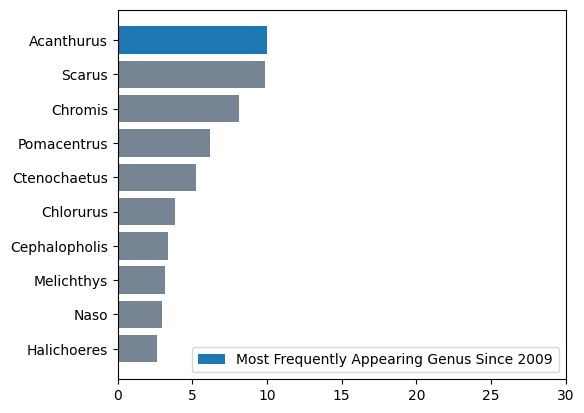

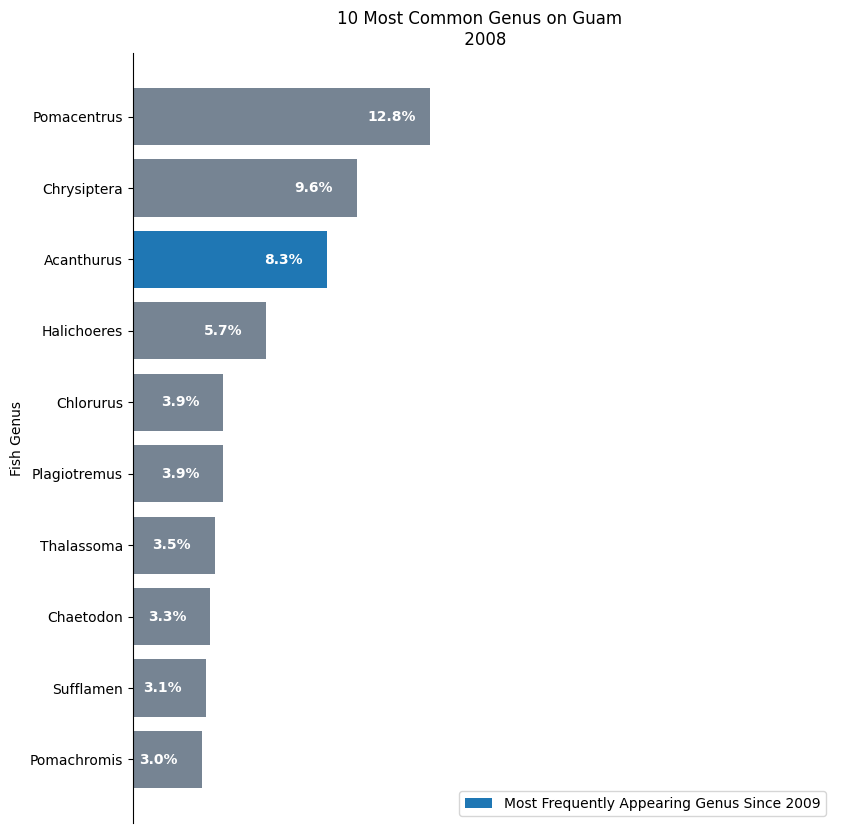

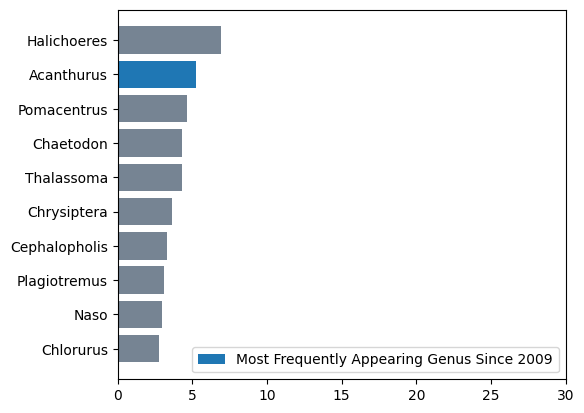

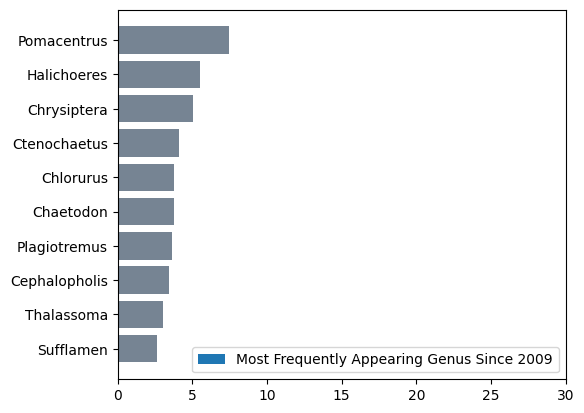

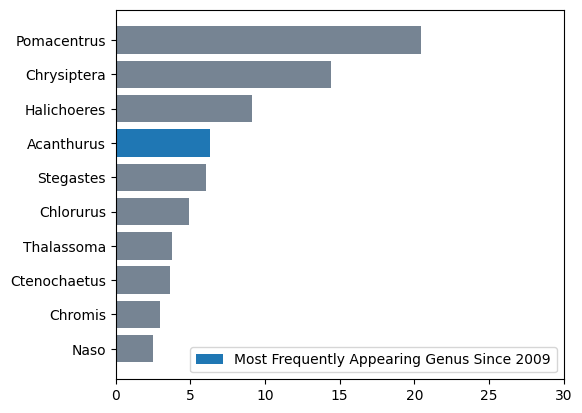

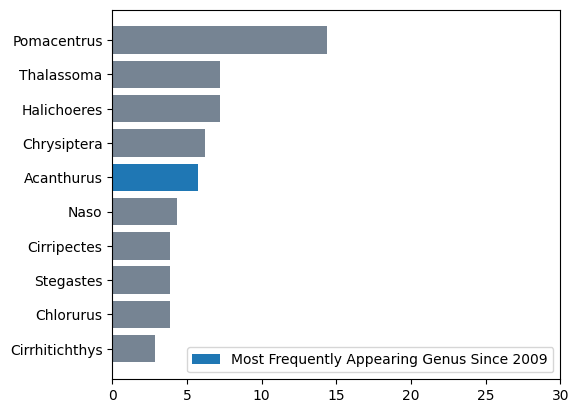

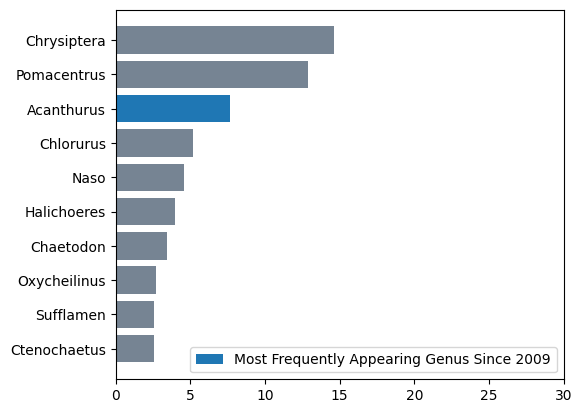

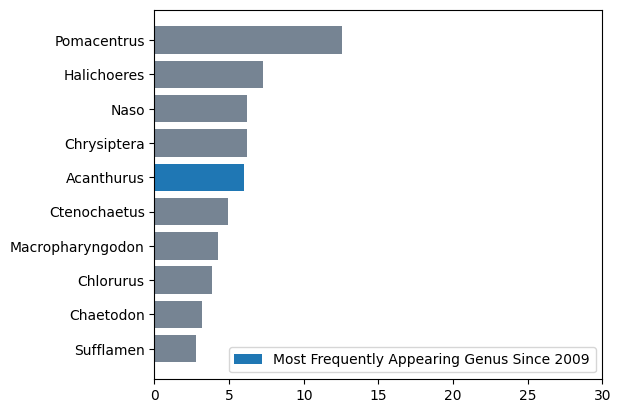

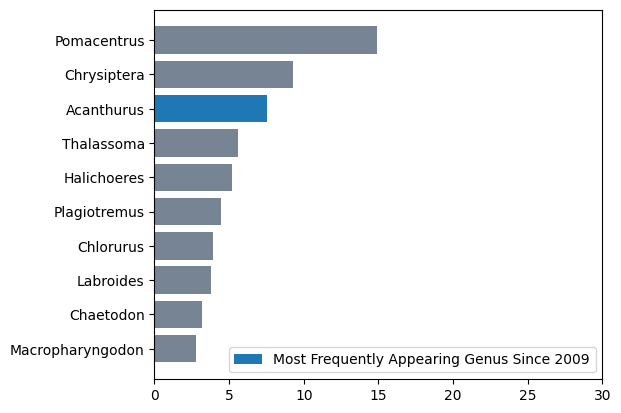

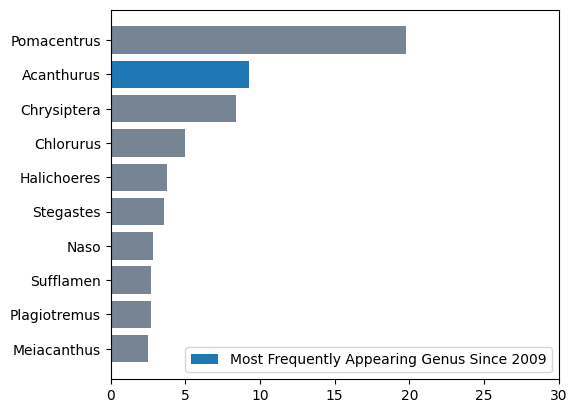

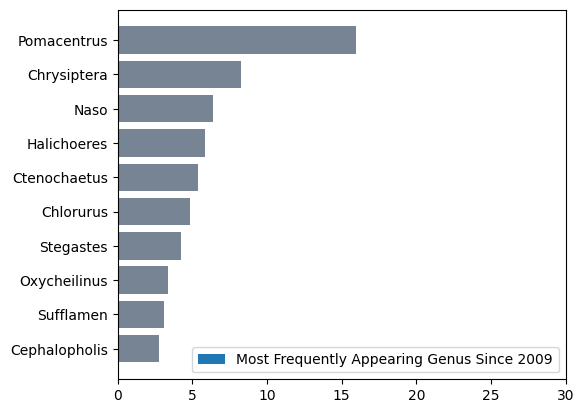

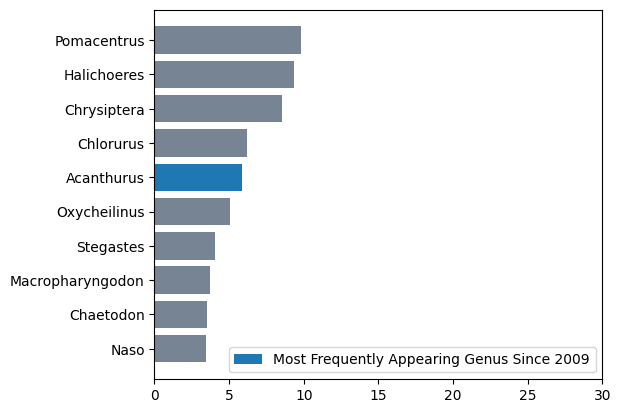

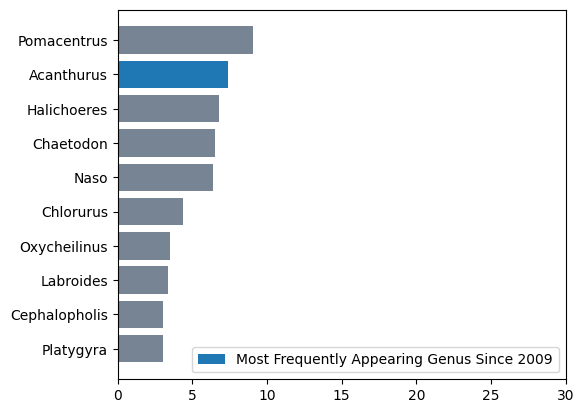

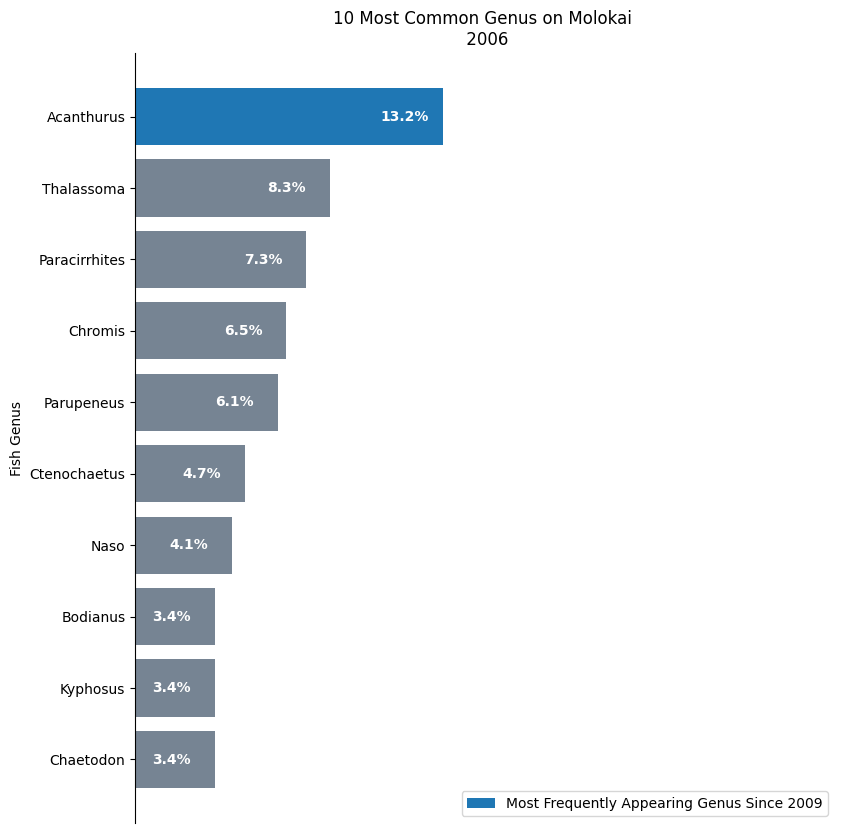

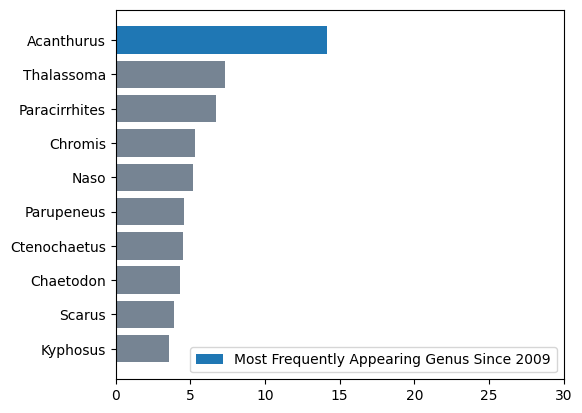

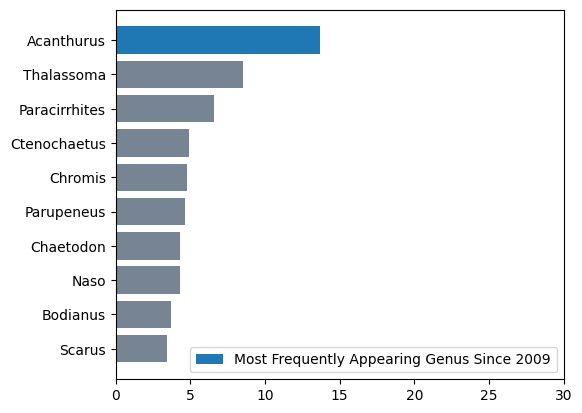

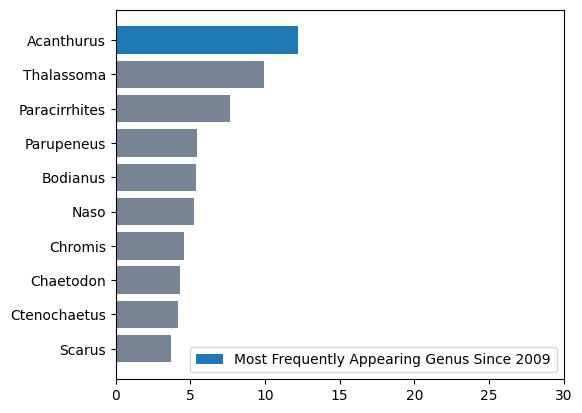

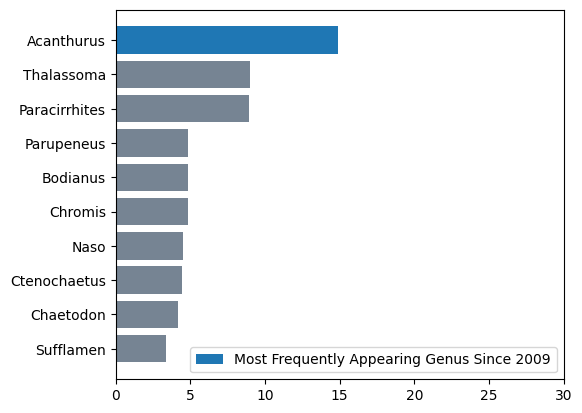

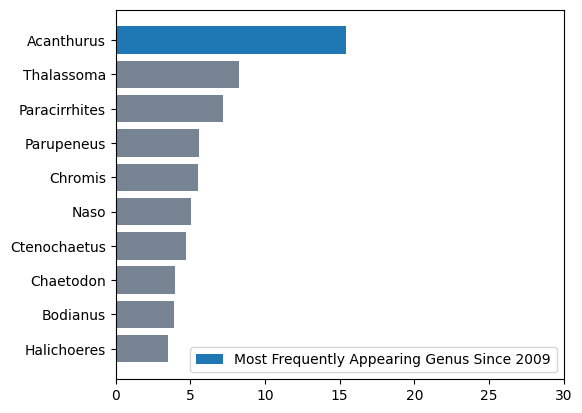

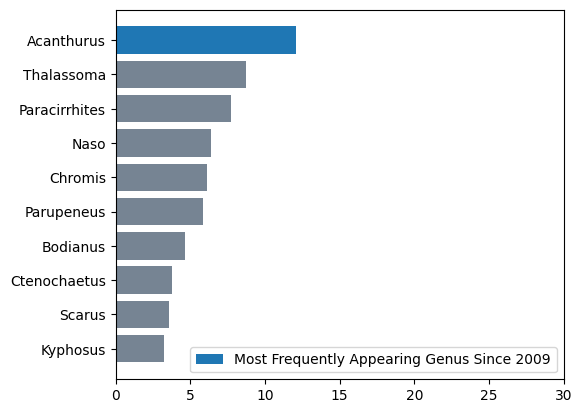

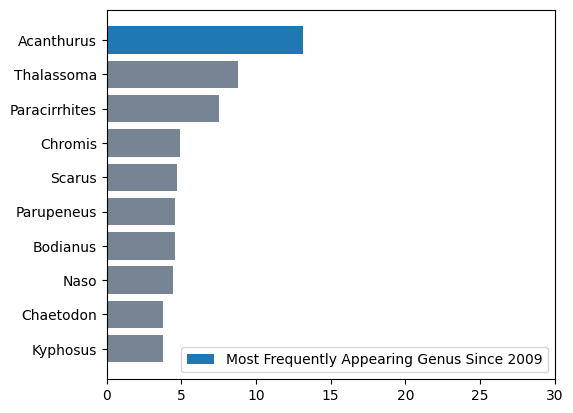

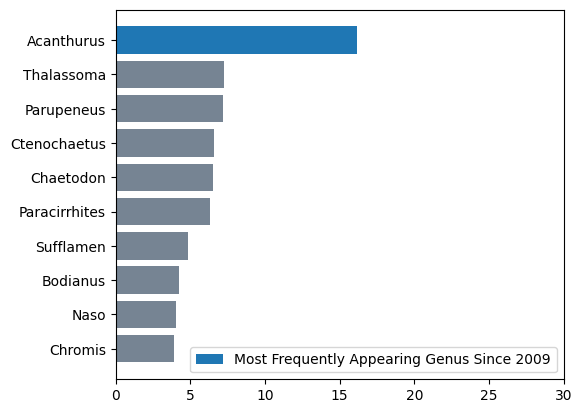

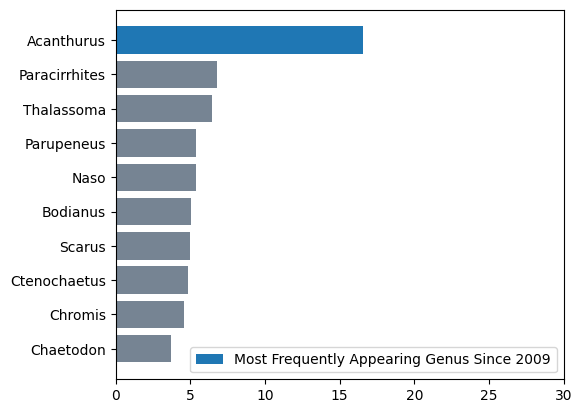

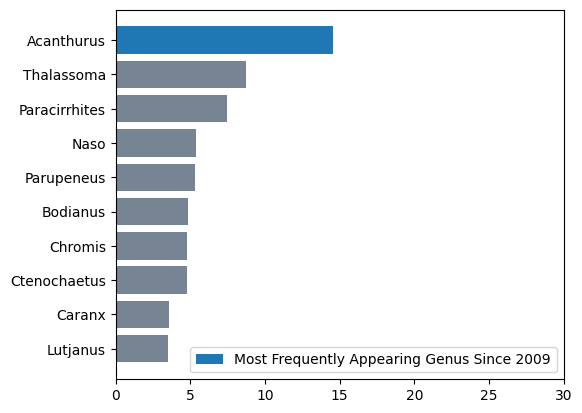

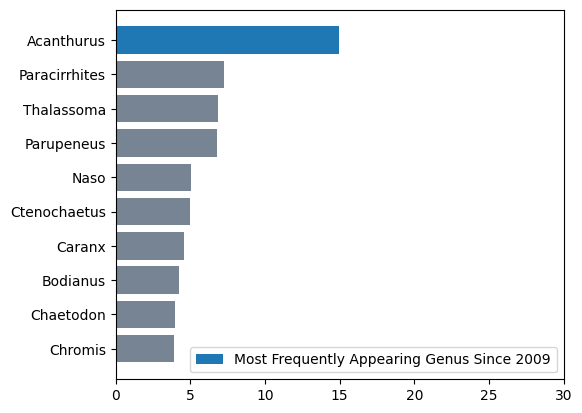

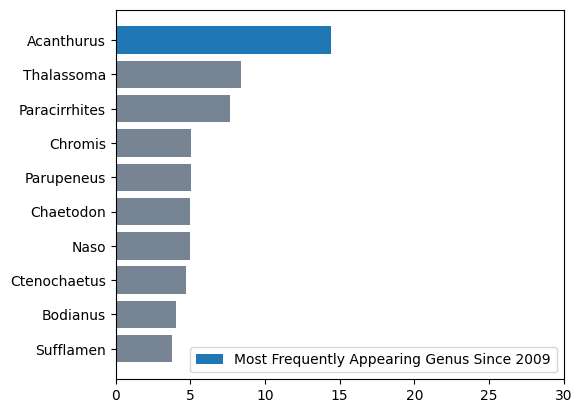

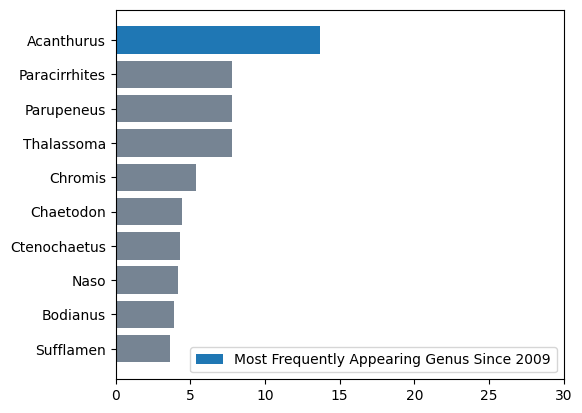

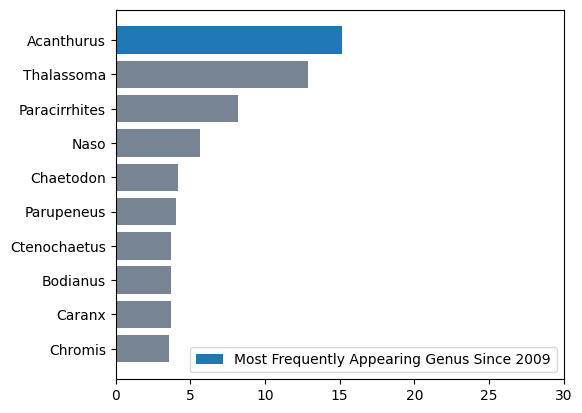

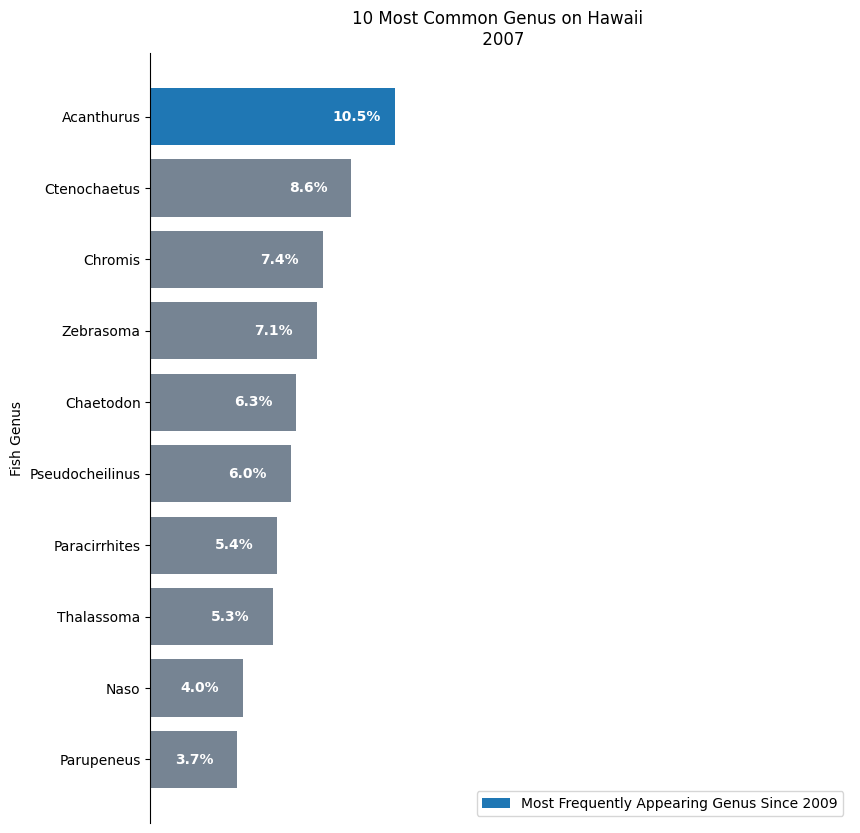

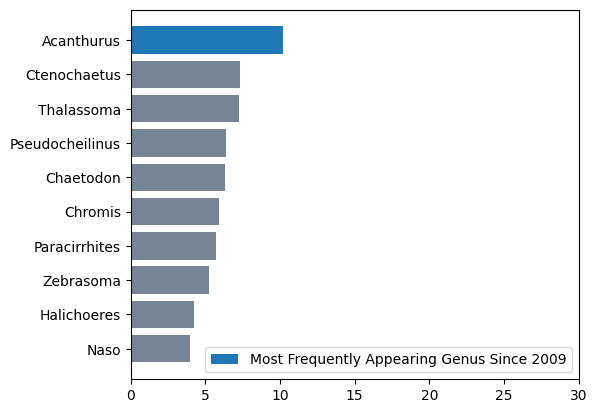

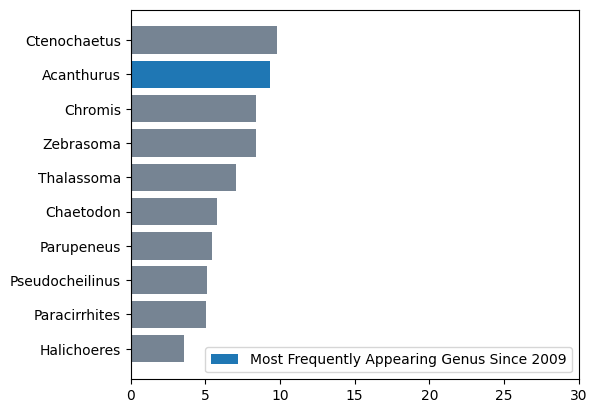

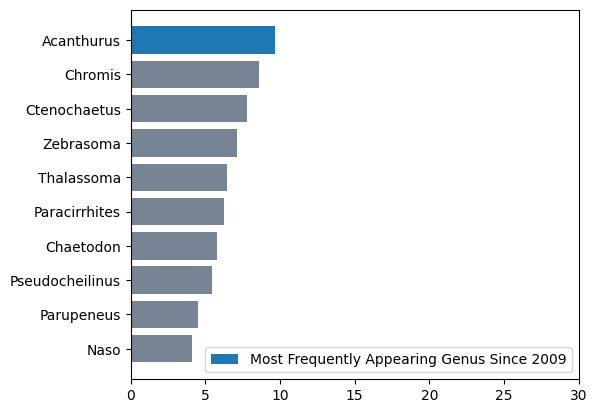

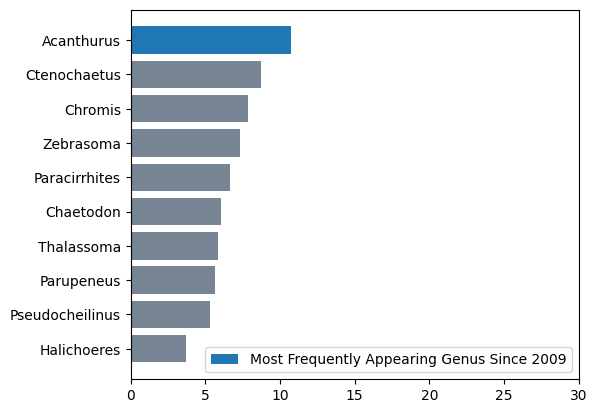

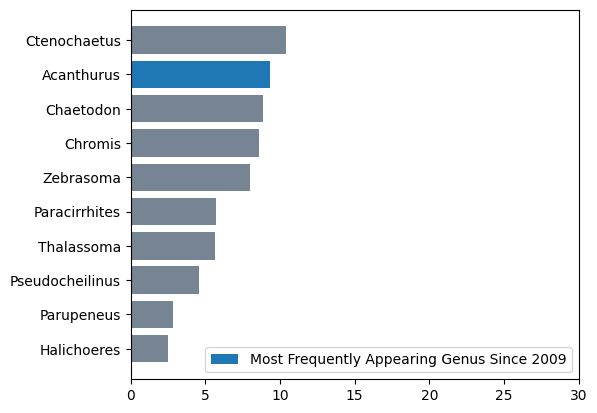

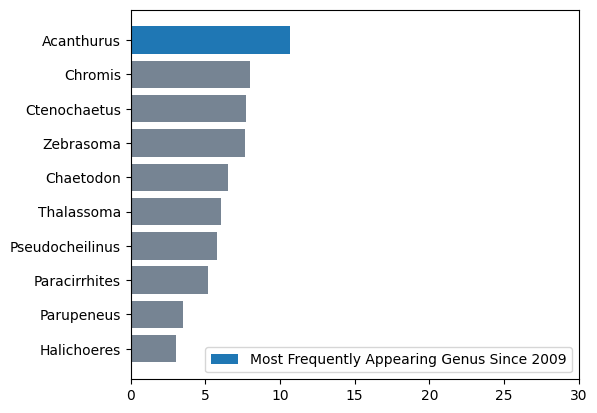

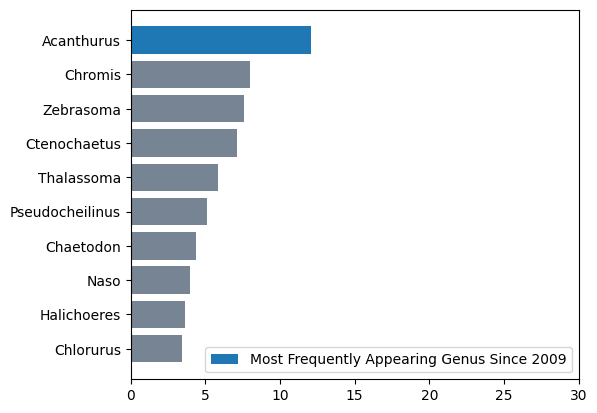

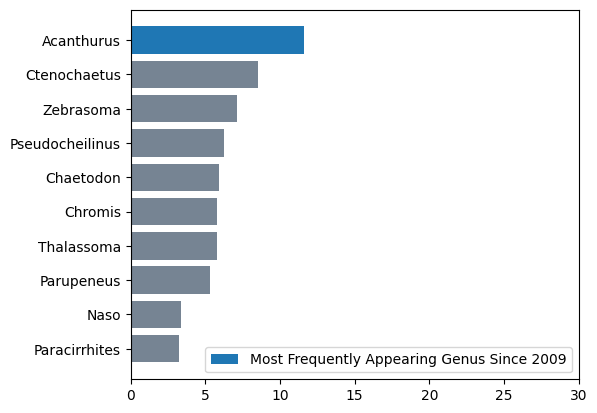

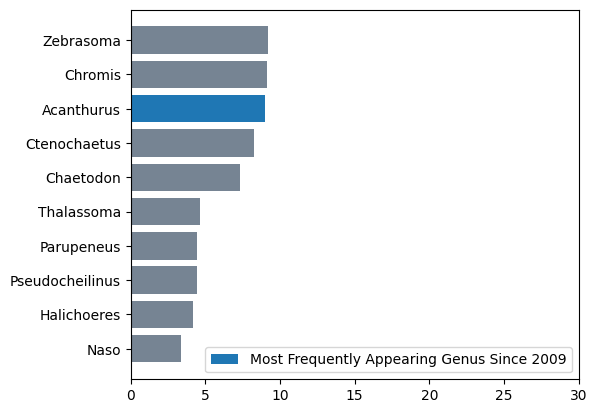

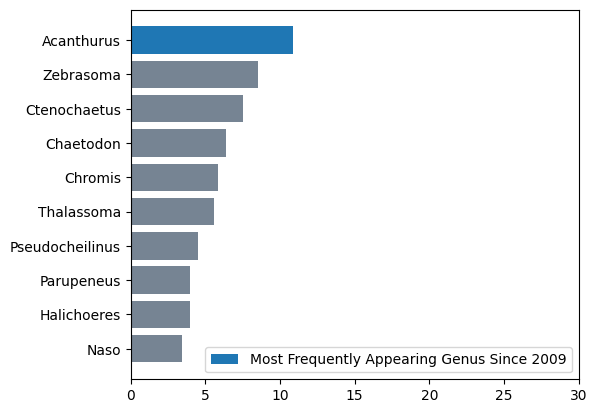

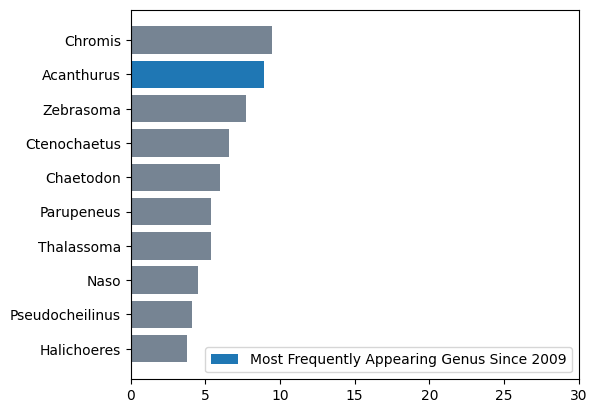

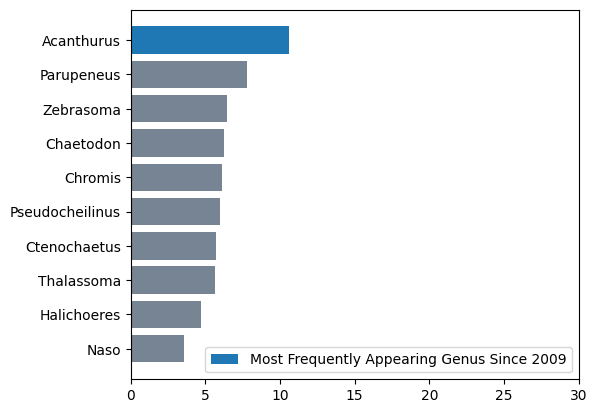

    fish     counts
0  Other  62.332828


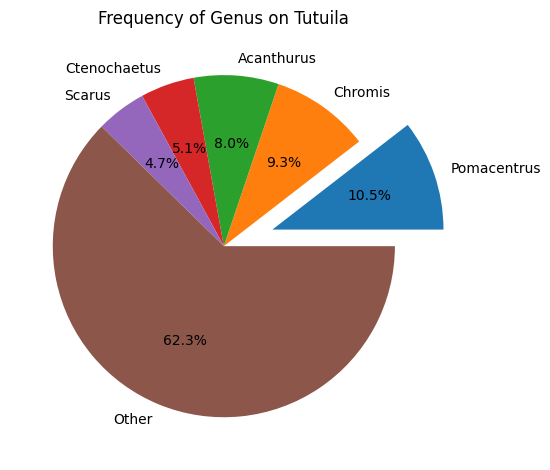

    fish     counts
0  Other  63.089467


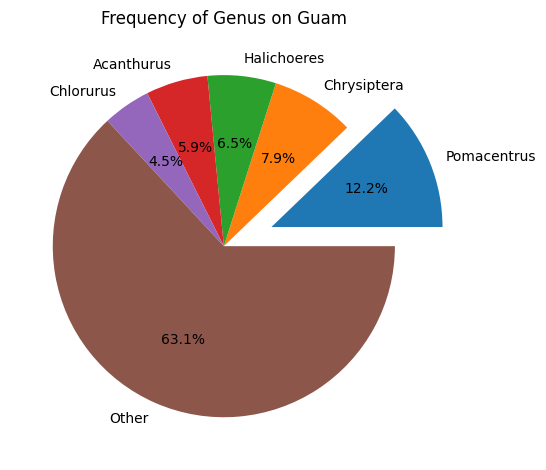

    fish     counts
0  Other  59.368635


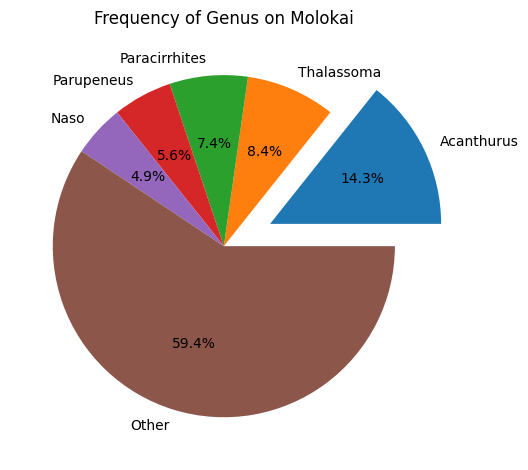

    fish     counts
0  Other  60.155677


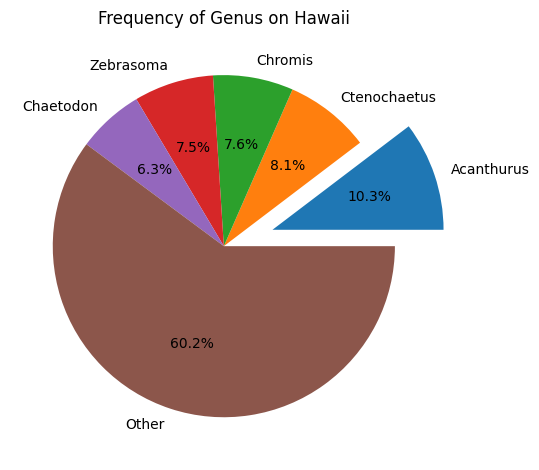

    fish     counts
0  Other  67.360138


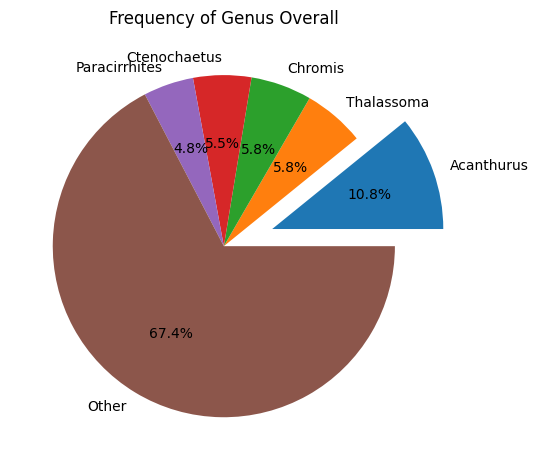

In [13]:
# example usage of coral reef biological condition analysis
get_fish_data_visualization(stats='Mean', vis='Density', taxon=False, window=4) 
get_fish_data_visualization(stats='Window', vis='Density', taxon=False, window=4) 
get_fish_data_visualization(stats='Scatter', vis='Density', taxon=False, window=4) 
get_fish_data_visualization(stats='Median', vis='Density', taxon=False, window=4)  
get_fish_data_visualization(stats='Mean', vis='Size', taxon=False, window=4) 
get_fish_data_visualization(stats='Window', vis='Size', taxon=False, window=4) 
get_fish_data_visualization(stats='Scatter', vis='Size', taxon=False, window=4) 
get_fish_data_visualization(stats='Median', vis='Size', taxon=False, window=4)  
get_taxon_over_time(vis='Density') 
get_taxon_piechart(vis='Density')

### Part III Coral Reef Environment Visualization Interface
In this part our group implement a interface for users to view the coral reef environment change on a map.
Our code will generate several HTML files. You can get a web-interface to view the coral reef environment change on a map after you open the HTML file in a browser.

In [ ]:
data_loader = Data_Loader_biomass_density_change()
df_density = data_loader.get_df_time_fish_density()
df_size = data_loader.get_df_time_juvenile_size()



def get_center_point(df):
    """
    Calculates the center point of all islands.

    Parameters
    ----------
    df : DataFrame
        The DataFrame containing the latitude and longitude of the islands.

    Returns
    -------
    (float, float)
        The latitude and longitude of the center point.
    """

    center_lat = df['Latitude'].mean()
    center_lon = df['Longitude'].mean()
    return center_lat, center_lon

def calculate_island_statistics(df_density, df_size):
    """
    Calculate the median and mean values of Heterogeneity and Bleaching Severity for each island.

    Parameters:
    ----------
    df_rugosity (DataFrame): DataFrame containing the Heterogeneity data.
    df_bleaching (DataFrame): DataFrame containing the Bleaching Severity data.

    Returns:
    -------
    tuple: Two DataFrames containing the statistical data for Heterogeneity and Bleaching Severity, respectively.
    """
    density_stats = df_density.groupby('Island')['Density'].agg(['median', 'mean'])
    size_stats = df_size.groupby('Island')['Size_mm'].agg(['median', 'mean'])
    return density_stats, size_stats

def plot_to_html_img(plot, popup_title, width=500, height=300):
    """
    Convert a Matplotlib plot to an HTML image and wrap it in a popup.

    Parameters:
    ----------
    plot (Matplotlib plot): The plot object to be converted.
    popup_title (str): The title of the popup.
    width (int, optional): The width of the image, defaults to 500 pixels.
    height (int, optional): The height of the image, defaults to 300 pixels.

    Returns:
    -------
    folium.Popup: The popup object containing the image.
    """
    output = BytesIO()
    plot.get_figure().savefig(output, format='png')
    plt.close(plot.get_figure())
    output.seek(0)
    encoded = base64.b64encode(output.getvalue()).decode('utf-8')
    html = f'<h4>{popup_title}</h4>'
    html += f'<img src="data:image/png;base64,{encoded}" style="width:{width}px;height:{height}px;">'
    iframe = folium.IFrame(html, width=width+20, height=height+60)
    return folium.Popup(iframe)

def create_island_map_density_size_overtime(df_density, df_size):
    """
    Create a map displaying the variation trends of Fish Density and Juvenile Size for all islands overtime.

    Parameters:
    ----------
    df_densit (DataFrame): DataFrame containing the Heterogeneity data.
    df_size (DataFrame): DataFrame containing the Bleaching Severity data.

    Returns:
    -------
    folium.Map: The created map object.
    """
    # Initialize the map:
    center_lat, center_lon = get_center_point(df_density)
    my_map = folium.Map(location=[center_lat, center_lon], zoom_start=5)

    # Iterate over the islands to create plots:
    for island in df_density['Island'].unique():
        island_df_density = df_density[df_density['Island'] == island]
        island_df_size = df_size[df_size['Island'] == island]
        lat, lon = get_center_point(island_df_density)

        # Create combined rugosity and bleaching plot
        fig, ax = plt.subplots()
        island_df_density.groupby(island_df_density['Start_Date'].dt.year)['Density'].mean().plot(ax=ax, legend=True)
        island_df_size.groupby(island_df_size['Start_Date'].dt.year)['Size_mm'].mean().plot(ax=ax, legend=True)
        plt.title(f'{island} - Density and Size Over Time')
        plt.legend(['Density', 'Size'])

        # Convert plot to HTML image and create popup
        popup = plot_to_html_img(ax, f'{island} - Density and Size Over Time', width=500, height=300)
        folium.Marker([lat, lon], popup=popup).add_to(my_map)

    # Save and return map:
    my_map.save('island_map_density_size_overtime.html')
    return my_map


def create_separate_markers_map_density_size(df_density, df_size, density_stats, size_stats):
    """
    Creates a map with separate markers for density and size statistics of each island.

    Parameters:
    ----------
    - df_density (DataFrame): DataFrame containing fish density data.
    - df_size (DataFrame): DataFrame containing juvenile size data.
    - density_stats (DataFrame): Statistics of fish density for each island.
    - size_stats (DataFrame): Statistics of juvenile size for each island.
    """

    # Obtain the center points of all islands for the initial map position
    center_lat, center_lon = get_center_point(df_density)
    combined_map = folium.Map(location=[center_lat, center_lon], zoom_start=5)

    # Iterate over each island and add statistical information
    for island in df_density['Island'].unique():
        island_density = density_stats.loc[island]
        
       # Calculate the center point of the island 
        island_lat, island_lon = get_center_point(df_density[df_density['Island'] == island])
        
        # Add a marker for Density
        folium.Marker(
            location=[island_lat, island_lon],
            popup=f"Density - Median: {island_density['median']}, Mean: {island_density['mean']}",
            icon=folium.Icon(color='blue')
        ).add_to(combined_map)
        
        
        if island in size_stats.index:
            island_size = size_stats.loc[island]
            folium.Marker(
                location=[island_lat + 0.02, island_lon + 0.02],  # 小幅偏移以区分标记
                popup=f"Size - Median: {island_size['median']}, Mean: {island_size['mean']}",
                icon=folium.Icon(color='green')
            ).add_to(combined_map)

    combined_map.save('separate_markers_map_density_size.html')

In [ ]:
# example usage
density_stats, size_stats = calculate_island_statistics(df_density, df_size)
    
create_island_map_density_size_overtime(df_density, df_size)
create_separate_markers_map_density_size(df_density, df_size, density_stats, size_stats)

In [ ]:
data_loader = Data_loader_coral_reef_health()
df_rugosity = data_loader.get_df_time_loc_rugosity()
df_bleaching = data_loader.get_df_time_location_bleaching()


def get_center_point(df):
    """
    Calculates the center point of all islands(To position the visualization of the image at the center and make the entire image more comprehensive.).

    Parameters
    ----------
    df : DataFrame
        The DataFrame containing the latitude and longitude of the islands.

    Returns
    -------
    (float, float)
        The latitude and longitude of the center point.
    """

    center_lat = df['Latitude'].mean()
    center_lon = df['Longitude'].mean()
    return center_lat, center_lon

def convert_severity(severity_str):
    """
    Convert the string representation of coral bleaching severity into numerical representation.

    Parameters:
    ----------
    severity_str (str): The string representation of bleaching severity (e.g., '0%', '1-25%').

    Returns:
    -------
    int or None: The corresponding numerical representation. Returns None if the string is not in the predefined mapping.
    """
    class_mapping = {'No Coral': 0, '0%': 1, '1-25%': 2, '26-50%': 3, '51-75%': 4, '76-100%': 5}
    return class_mapping.get(severity_str, None)  # # Returns None if the key is not present in the dictionary.

df_bleaching['Severity_Num'] = df_bleaching['Severity'].apply(convert_severity)


def calculate_island_statistics(df_rugosity, df_bleaching):
    """
    Calculate the median and mean values of Heterogeneity and Bleaching Severity for each island.

    Parameters:
    ----------
    df_rugosity (DataFrame): DataFrame containing the Heterogeneity data.
    df_bleaching (DataFrame): DataFrame containing the Bleaching Severity data.

    Returns:
    -------
    tuple: Two DataFrames containing the statistical data for Heterogeneity and Bleaching Severity, respectively.
    """

    rugosity_stats = df_rugosity.groupby('Island')['Heterogeneity'].agg(['median', 'mean'])
    bleaching_stats = df_bleaching.groupby('Island')['Severity_Num'].agg(['median', 'mean'])
    return rugosity_stats, bleaching_stats


def plot_to_html_img(plot, popup_title, width=500, height=300):
    """
    Convert a Matplotlib plot to an HTML image and wrap it in a popup.

    Parameters:
    ----------
    plot (Matplotlib plot): The plot object to be converted.
    popup_title (str): The title of the popup.
    width (int, optional): The width of the image, defaults to 500 pixels.
    height (int, optional): The height of the image, defaults to 300 pixels.

    Returns:
    -------
    folium.Popup: The popup object containing the image.
    """

    output = BytesIO()
    plot.get_figure().savefig(output, format='png')
    plt.close(plot.get_figure())
    output.seek(0)
    encoded = base64.b64encode(output.getvalue()).decode('utf-8')
    html = f'<h4>{popup_title}</h4>'
    html += f'<img src="data:image/png;base64,{encoded}" style="width:{width}px;height:{height}px;">'
    iframe = folium.IFrame(html, width=width+20, height=height+60)
    return folium.Popup(iframe)


def create_island_map_rugosity_bleaching_overtime(df_rugosity, df_bleaching):
    """
    Create a map displaying the variation trends of Heterogeneity and Bleaching Severity for all islands overtime.

    Parameters:
    ----------
    df_rugosity (DataFrame): DataFrame containing the Heterogeneity data.
    df_bleaching (DataFrame): DataFrame containing the Bleaching Severity data.

    Returns:
    -------
    folium.Map: The created map object.
    """

    # Initialize the map:
    center_lat, center_lon = get_center_point(df_rugosity)
    my_map = folium.Map(location=[center_lat, center_lon], zoom_start=5)

    # Iterate over the islands to create plots:
    for island in df_rugosity['Island'].unique():
        island_df_rugosity = df_rugosity[df_rugosity['Island'] == island]
        island_df_bleaching = df_bleaching[df_bleaching['Island'] == island]
        lat, lon = get_center_point(island_df_rugosity)

        # Create combined rugosity and bleaching plot
        fig, ax = plt.subplots()
        island_df_rugosity.groupby(island_df_rugosity['Start_Date'].dt.year)['Heterogeneity'].mean().plot(ax=ax, legend=True)
        island_df_bleaching.groupby(island_df_bleaching['Start_Date'].dt.year)['Severity_Num'].mean().plot(ax=ax, legend=True)
        plt.title(f'{island} - Rugosity and Bleaching Over Time')
        plt.legend(['Rugosity', 'Bleaching'])

        # Convert plot to HTML image and create popup
        popup = plot_to_html_img(ax, f'{island} - Rugosity and Bleaching Over Time', width=500, height=300)
        folium.Marker([lat, lon], popup=popup).add_to(my_map)

    # Save and return map:
    my_map.save('island_map_rugosity_bleaching_overtime.html')
    return my_map


def create_combined_eachIslandstats_map_rugosity_bleaching(df_rugosity, df_bleaching, rugosity_stats, bleaching_stats):
    """
    Create a map displaying the variation trends of Heterogeneity and Bleaching Severity for each island.

    Parameters:
    ----------
    df_rugosity (DataFrame): DataFrame containing the Heterogeneity data.
    df_bleaching (DataFrame): DataFrame containing the Bleaching Severity data.
    rugosity_stats (DataFrame): DataFrame containing the statistical information for Heterogeneity.
    bleaching_stats (DataFrame): DataFrame containing the statistical information for Bleaching Severity.

    """

    islands = df_rugosity['Island'].unique()
    
    for island in islands:
        island_rugosity_df = df_rugosity[df_rugosity['Island'] == island]
        island_bleaching_df = df_bleaching[df_bleaching['Island'] == island]
        
        if not island_rugosity_df.empty and not island_bleaching_df.empty:
            avg_lat, avg_lon = get_center_point(island_rugosity_df)

            map = folium.Map(location=[avg_lat, avg_lon], zoom_start=10)

            # Add Heterogeneity statistical information.
            rugosity_stat = rugosity_stats.loc[island]
            folium.Marker(
                location=[avg_lat, avg_lon],
                popup=f"{island} - Heterogeneity Median: {rugosity_stat['median']}, Mean: {rugosity_stat['mean']}",
                icon=folium.Icon(color="blue")
            ).add_to(map)

            # Add Bleaching Severity statistical information.
            bleaching_stat = bleaching_stats.loc[island]
            folium.Marker(
                location=[avg_lat + 0.02, avg_lon + 0.02],  # Add a slight offset to differentiate the markers.
                popup=f"{island} - Bleaching Severity Median: {bleaching_stat['median']}, Mean: {bleaching_stat['mean']}",
                icon=folium.Icon(color="red")
            ).add_to(map)

            map.save(f"{island}_combined_eachIslandstats_map_rugosity_bleaching.html")


def create_combined_island_map_rugosity_bleaching_statisctic(df_rugosity, df_bleaching, rugosity_stats, bleaching_stats):
    """
    Create a map displaying the statistical data of Heterogeneity and Bleaching Severity for all islands.

    Parameters:
    ----------
    df_rugosity (DataFrame): DataFrame containing the Heterogeneity data.
    df_bleaching (DataFrame): DataFrame containing the Bleaching data.
    rugosity_stats (DataFrame): DataFrame containing the statistical data for Heterogeneity.
    bleaching_stats (DataFrame): DataFrame containing the statistical data for Bleaching Severity.

    Returns:
    -------
    folium.Map: The created map object.
    """
    
    # # Get the center points of all islands for the initial map position.
    center_lat, center_lon = get_center_point(df_rugosity)

    # Create a map instance
    combined_map = folium.Map(location=[center_lat, center_lon], zoom_start=5)

    # Iterate over each island and add statistical information
    for island in df_rugosity['Island'].unique():
        island_rugosity = rugosity_stats.loc[island]
        island_bleaching = bleaching_stats.loc[island]

        # Calculate the center point of the island
        island_lat, island_lon = get_center_point(df_rugosity[df_rugosity['Island'] == island])

        # Add markers for Heterogeneity and Bleaching
        folium.Marker(
            location=[island_lat, island_lon],
            popup=(f"{island} - Heterogeneity\n"
                   f"Median: {island_rugosity['median']}, Mean: {island_rugosity['mean']}\n"
                   f"Bleaching Severity\n"
                   f"Median: {island_bleaching['median']}, Mean: {island_bleaching['mean']}"),
            icon=folium.Icon(color='green')
        ).add_to(combined_map)

    # Save the map as an HTML file
    combined_map.save('combined_island_map_rugosity_bleaching_statisctic.html')

def create_separate_markers_map_rugosity_bleaching(df_rugosity, df_bleaching, rugosity_stats, bleaching_stats):
    """
    Creates a map with separate markers for rugosity and bleaching statistics of each island.

    Parameters:
    - df_rugosity (DataFrame): DataFrame containing rugosity data.
    - df_bleaching (DataFrame): DataFrame containing severity data.
    - rugosity_stats (DataFrame): Statistics of fish rugosity for each island.
    - bleaching_stats (DataFrame): Statistics of bleaching severity size for each island.

    """
    # Obtain the center points of all islands for the initial map position
    center_lat, center_lon = get_center_point(df_rugosity)

    # Create a map instance
    combined_map = folium.Map(location=[center_lat, center_lon], zoom_start=5)

    # Iterate over each island and add statistical information
    for island in df_rugosity['Island'].unique():
        island_rugosity = rugosity_stats.loc[island]
        island_bleaching = bleaching_stats.loc[island]

        # Calculate the center point of the island 
        island_lat, island_lon = get_center_point(df_rugosity[df_rugosity['Island'] == island])

        # Add a marker for Heterogeneity
        folium.Marker(
            location=[island_lat, island_lon],
            popup=f"Heterogeneity - Median: {island_rugosity['median']}, Mean: {island_rugosity['mean']}",
            icon=folium.Icon(color='blue')
        ).add_to(combined_map)

        # Add a marker for Bleaching Severity, slightly offset the position for differentiation
        folium.Marker(
            location=[island_lat + 0.02, island_lon + 0.02],
            popup=f"Bleaching Severity - Median: {island_bleaching['median']}, Mean: {island_bleaching['mean']}",
            icon=folium.Icon(color='red')
        ).add_to(combined_map)

    # Save the map as an HTML file 
    combined_map.save('separate_markers_map_rugosity_bleaching.html')

In [ ]:
# example usage
rugosity_stats, bleaching_stats = calculate_island_statistics(df_rugosity, df_bleaching)

create_island_map_rugosity_bleaching_overtime(df_rugosity, df_bleaching) 
create_combined_eachIslandstats_map_rugosity_bleaching(df_rugosity, df_bleaching, rugosity_stats, bleaching_stats) 
create_combined_island_map_rugosity_bleaching_statisctic(df_rugosity, df_bleaching, rugosity_stats, bleaching_stats)
create_separate_markers_map_rugosity_bleaching(df_rugosity, df_bleaching, rugosity_stats, bleaching_stats)